# Sentiment Analysis & Text Style Transfer on Semi-Parallel Movie Critic Review Corpora Using NLP Translation Techniques

### Charlie Glass

#### August 2023

The recent dramatic increase in public consumption generative AI tools—like Chat GPT—has created the possibility of almost instantaneously writing original content in the styles of different authors—even those who have long passed away. This research focuses on such text-style transfer trained on semi-parallel corpora, using Encoder-Decoder and Sequence-to-Sequence architectures for two tasks: translating a positive review into a negative review, and translating reviews of the late, popular movie critic Roger Ebert into generic critic reviews. We also trained sentiment analysis models (using multilayer perceptron neural networks, CNNs, BERT pretrained models with CNNs), and used the top-performing sentiment analysis model to evaluate the success of the positive-negative translation capturing the right sentiment.

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv')
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
reviews.describe()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
count,1130017,1111488,1130017,1130017,1130017,824081,1130017,1064211
unique,17712,11108,2,2230,2,814,8015,949181
top,m/star_wars_the_rise_of_skywalker,Emanuel Levy,False,New York Times,Fresh,3/5,2000-01-01,Parental Content Review
freq,992,8173,841481,13293,720210,90273,48019,267


In [ ]:
#check if there are null values in each column
reviews.isnull().sum()

rotten_tomatoes_link         0
critic_name              18529
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
review_content           65806
dtype: int64

In [ ]:
len(reviews)

1130017

Our full reviews dataset is 1M+ rows long, but we have null values for critic name and review content that is critical for our project. We'll drop those null rows, and we'll make sure there are no duplicates for a given movie/critic/review combo.

In [ ]:
reviews = reviews[(reviews.critic_name.notnull()) & (reviews.review_content.notnull())]
reviews.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name', 'review_content'], inplace=True)
len(reviews)

942921

Now our dataset is 943K rows long. We're ready to split our dataset into an 80/10/10 training/validation/test split for our upcoming sentiment analysis.

In [ ]:
reviews_train = reviews.sample(frac=0.8, random_state=1)
reviews_train

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
563579,m/mean_creek,Brad Slager,False,Film Threat,Fresh,3.5/5,2004-06-12,For a first time director to provoke such impr...
74436,m/1205380-crazies,Adam Graham,True,Detroit News,Rotten,C,2010-02-26,"If there's a message in all this, it's buried ..."
587192,m/moonlight_2016,Hanna B,False,Film Threat,Fresh,NaN,2019-08-06,It will forever live as one of the most profou...
1027199,m/the_wave_2020,Dave Canfield,False,ScreenAnarchy,Fresh,NaN,2019-12-05,"As movies featuring bad drug trips go, it rank..."
1102774,m/whiplash_2014,Elliott Noble,False,Sky Cinema,Fresh,5/5,2015-01-15,"Come the last beat, you'll probably be exhaust..."
...,...,...,...,...,...,...,...,...
184089,m/black_christmas,Mark Palermo,False,"The Coast (Halifax, Nova Scotia)",Rotten,NaN,2007-01-03,"Katie Cassidy, Michelle Trachtenberg, Mary Eli..."
81349,m/1217700-kick_ass,Anders Wotzke,False,Moviedex,Fresh,4.5/5,2010-03-19,Kick-Ass is what Spider-Man would have looked ...
539295,m/loveless_2018,Glenn Heath Jr.,False,San Diego CityBeat,Fresh,NaN,2018-08-20,"Being the blunt object that it is, Loveless in..."
624817,m/omar,Donald Clarke,False,Irish Times,Fresh,4/5,2014-05-30,The end result is a nerve-rattling entertainme...


We'll want to set up a baseline for our sentiment analysis. One good way to start is seeing how much of our dataset is 'Fresh' (positive), and predicting the majority class.

In [ ]:
sum(reviews_train.review_type=='Fresh')/len(reviews_train)

0.6395046245908659

It looks like 64% of our training dataset is 'Fresh'. So, we'll set up a baseline model that predicts 'Fresh' all the time. First, we'll finish setting up our training/validation/test split.

In [ ]:
reviews_other = reviews[~reviews.index.isin(reviews_train.index)]
reviews_other

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
13,m/0814255,Joshua Tyler,False,CinemaBlend,Fresh,3/5,2010-02-11,The best thing you can say about Chris Columbu...
26,m/0814255,James Rocchi,True,MSN Movies,Fresh,3/5,2010-02-11,An attempt to steal some of Harry Potter's thu...
38,m/0814255,Michael Phillips,True,Chicago Tribune,Rotten,2/4,2010-02-11,Even with all its computer-generated fireballs...
41,m/0814255,Rich Cline,False,Shadows on the Wall,Fresh,3/5,2010-02-11,The Greek-gods premise lets the filmmakers ind...
...,...,...,...,...,...,...,...,...
1129975,m/zootopia,Danielle Solzman,False,Solzy at the Movies,Fresh,5/5,2020-09-24,Zootopia is the rare animated Disney film that...
1129984,m/zorba_the_greek,Wendy Michener,False,Maclean's Magazine,Rotten,NaN,2019-07-16,"As a whole the picture doesn't come off, partl..."
1130003,m/zulu,Will Heaven,True,Daily Telegraph (UK),Fresh,NaN,2017-07-10,"It may not be truthful - but, my God, the resu..."
1130004,m/zulu,Tony Sloman,False,Radio Times,Fresh,5/5,2017-07-10,The movie is a revelation.


In [ ]:
reviews_val = reviews_other.sample(frac=0.5, random_state=1)
reviews_test = reviews_other[~reviews_other.index.isin(reviews_val.index)]

In [ ]:
def baseline_predict(X, y):
    return np.array([1 for i in y]) #we will label 'Fresh' as 1

In [ ]:
def accuracy(preds, actual):
    return sum([p==a for p, a in zip(preds, actual)])/len(actual)

In [ ]:
baseline_train_preds = baseline_predict(reviews_train.review_content, reviews_train.review_type)
baseline_val_preds = baseline_predict(reviews_val.review_content, reviews_val.review_type)
baseline_test_preds = baseline_predict(reviews_test.review_content, reviews_test.review_type)

In [ ]:
#Train accuracy
accuracy(baseline_train_preds, [1 if rt=='Fresh' else 0 for rt in reviews_train.review_type])

0.6395046245908659

In [ ]:
#Val accuracy
accuracy(baseline_val_preds, [1 if rt=='Fresh' else 0 for rt in reviews_val.review_type])

0.6392270818309083

In [ ]:
#Test accuracy
accuracy(baseline_test_preds, [1 if rt=='Fresh' else 0 for rt in reviews_test.review_type])

0.6409027276969415

So, our baseline model is not overfitting, and our test accuracy is <b>64%</b>. How much better can we do than this? Let's first try a bag-of-words approach to see how much improvement we can get by incrementally adding complexity.

In [ ]:
CountVec = CountVectorizer(ngram_range=(1,1),
                           stop_words='english',
                          max_features=500) #max 500 word vocabulary. we'll see bag of words can't handle as many words as other methods.

#transform
Count_data = CountVec.fit_transform([sent for sent in reviews_train.review_content])

#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())
print(cv_dataframe)

        act  acted  acting  action  actor  actors  actually  adaptation  \
0         0      0       0       0      0       0         0           0   
1         0      0       0       0      0       0         0           0   
2         0      0       0       0      0       0         0           0   
3         0      0       0       0      0       0         0           0   
4         0      0       0       0      0       0         0           0   
...     ...    ...     ...     ...    ...     ...       ...         ...   
754332    0      0       0       0      0       0         0           0   
754333    0      0       0       0      0       0         0           0   
754334    0      0       0       0      0       0         0           0   
754335    0      0       0       0      0       0         0           0   
754336    0      0       0       0      0       0         0           0   

        adventure  age  ...  worst  worth  worthy  writer  written  wrong  \
0               0    0

In [ ]:
X_train = Count_data.toarray()
X_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_train = np.array([1 if rt=='Fresh' else 0 for rt in reviews_train.review_type])
y_train

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
X_val = CountVec.transform([sent for sent in reviews_val.review_content])
y_val = np.array([1 if rt=='Fresh' else 0 for rt in reviews_val.review_type])

In [ ]:
X_test = CountVec.transform([sent for sent in reviews_test.review_content])
y_test = np.array([1 if rt=='Fresh' else 0 for rt in reviews_test.review_type])

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.12.0


In [ ]:
#Basic bag of words logistic regression model
linear_model = keras.Sequential([
    
    keras.layers.Dense(1, activation='sigmoid')
])

linear_model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])        

linear_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
23574/23574 [==============================] - 66s 3ms/step - loss: 0.5713 - accuracy: 0.6942 - val_loss: 0.5632 - val_accuracy: 0.7023
Epoch 2/15
23574/23574 [==============================] - 59s 3ms/step - loss: 0.5624 - accuracy: 0.7021 - val_loss: 0.5631 - val_accuracy: 0.7020
Epoch 3/15
23574/23574 [==============================] - 59s 3ms/step - loss: 0.5624 - accuracy: 0.7021 - val_loss: 0.5633 - val_accuracy: 0.7022
Epoch 4/15
23574/23574 [==============================] - 59s 3ms/step - loss: 0.5624 - accuracy: 0.7023 - val_loss: 0.5631 - val_accuracy: 0.7028
Epoch 5/15
23574/23574 [==============================] - 60s 3ms/step - loss: 0.5624 - accuracy: 0.7022 - val_loss: 0.5635 - val_accuracy: 0.7030
Epoch 6/15
23574/23574 [==============================] - 59s 3ms/step - loss: 0.5625 - accuracy: 0.7022 - val_loss: 0.5635 - val_accuracy: 0.7014
Epoch 7/15
23574/23574 [==============================] - 59s 3ms/step - loss: 0.5625 - accuracy: 0.7022 - val_loss: 0

In [ ]:
test_preds = linear_model.predict(X_test)

2947/2947 [==============================] - 5s 2ms/step


In [ ]:
test_preds_full = (test_preds[:,0]>0.5).astype(int)
test_preds_full

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
test_linear_acc = accuracy(test_preds_full, y_test)
test_linear_acc

0.7040894243414075

No overfitting here, and an improvement in test accuracy to <b>70%</b>. Not bad for just word counting!

Let's see where our model is going wrong using the optional "review score" field, which is the critic's own numeric/letter grade.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#let's look at the different review scroes in our dataset
set(reviews_train.review_score)

{'0',
 '0.02/5',
 '0.05/4',
 '0.1/5',
 '0.13/1',
 '0.13/5',
 '0.2/5',
 '0.21/10',
 '0.25/4',
 '0.3/5',
 '0.4/5',
 '0.5/10',
 '0.5/4',
 '0.5/5',
 '0.5/5.5',
 '0.58/1',
 '0.59/1',
 '0.6/1',
 '0.6/10',
 '0.65/10',
 '0.664363/10',
 '0.666/4',
 '0.7221/10',
 '0.75/10',
 '0.75/5',
 '0.8/10',
 '0.8/5',
 '0.81/1',
 '0.82/10',
 '0.85/10',
 '0.9/10',
 '0/10',
 '0/100',
 '0/1000',
 '0/4',
 '0/5',
 '0/6',
 '1',
 '1.1/10',
 '1.1/2',
 '1.1/5',
 '1.2/10',
 '1.2/5',
 '1.24/5',
 '1.25/4',
 '1.25/5',
 '1.3/5',
 '1.35/5',
 '1.4/10',
 '1.4/4',
 '1.4/5',
 '1.5/10',
 '1.5/2',
 '1.5/3',
 '1.5/4',
 '1.5/5',
 '1.5/6',
 '1.5242228/10',
 '1.6/5',
 '1.62/5',
 '1.7/5',
 '1.75/10',
 '1.75/4',
 '1.75/5',
 '1.8/10',
 '1.8/4',
 '1.8/5',
 '1.82/10',
 '1.88/10',
 '1.9/5',
 '1.9528/10',
 '1/1',
 '1/10',
 '1/3',
 '1/4',
 '1/5',
 '1/54',
 '1/6',
 '10',
 '10.50/20',
 '10/10',
 '10/100',
 '10/20',
 '10/90',
 '100/100',
 '11.5/20',
 '11/20',
 '12.5/20',
 '12/100',
 '12/20',
 '13.5/20',
 '13/100',
 '13/20',
 '14',
 '14.5/20',


We see mostly numeric ratio grades, but also letter grades at the end. We'll convert all grades to float type, including letter grades, for simplicity.

In [ ]:
import re
test_str = '99/100'
float(re.search('(.*)/(.*)', test_str).group(1))/float(re.search('(.*)/(.*)', test_str).group(2))

0.99

In [ ]:
#letter grade to numeric conversion
#this is very basic, and can lead to some trouble when comparing to the other numeric grades. we'll keep this in mind.
grades = {'A': 1., 'B': .8, 'C': .6, 'D': .4, 'F': .2}
grades

{'A': 1.0, 'B': 0.8, 'C': 0.6, 'D': 0.4, 'F': 0.2}

In [ ]:
#converting scores to numeric
new_score = []
for rs in reviews_train.review_score:
  if re.search('/', str(rs)):
    # print(rs)
    try:
      new_score.append(float(re.search('(.*)/(.*)', rs).group(1))/float(re.search('(.*)/(.*)', rs).group(2)))
    except:
      new_score.append(float(re.search('(.*)/(.*)', rs).group(1))/100.)
  elif re.search('A|B|C|D|F', str(rs)):
    new_score.append(grades[rs[0]])
  else:
    new_score.append(np.nan)



In [ ]:
new_score

[0.7,
 0.6,
 nan,
 nan,
 1.0,
 0.9,
 0.75,
 0.6,
 1.0,
 0.375,
 0.75,
 0.8,
 0.6,
 0.8,
 0.25,
 nan,
 nan,
 0.7,
 0.8,
 nan,
 nan,
 nan,
 0.75,
 0.6,
 0.8,
 0.4,
 0.8,
 0.8,
 0.625,
 nan,
 nan,
 nan,
 0.75,
 nan,
 0.5,
 nan,
 0.8,
 nan,
 0.2,
 0.75,
 nan,
 0.6,
 0.6,
 0.5,
 0.6,
 0.8,
 nan,
 0.4,
 0.875,
 nan,
 nan,
 0.4,
 nan,
 0.65,
 nan,
 0.4,
 0.2,
 0.6,
 0.625,
 0.8,
 0.5,
 0.625,
 0.6,
 nan,
 0.875,
 nan,
 0.6,
 0.75,
 0.625,
 0.6,
 1.0,
 0.75,
 0.75,
 0.25,
 0.7,
 0.5,
 0.6,
 1.0,
 nan,
 nan,
 0.75,
 0.6,
 nan,
 nan,
 0.4,
 0.75,
 nan,
 nan,
 0.625,
 nan,
 0.6,
 0.375,
 0.6,
 0.4,
 0.6,
 0.625,
 nan,
 0.8,
 0.8,
 0.6,
 0.7,
 nan,
 0.75,
 1.0,
 nan,
 0.6,
 0.6,
 0.6,
 0.8,
 0.6,
 nan,
 nan,
 0.8,
 nan,
 1.0,
 0.875,
 0.9,
 nan,
 nan,
 nan,
 0.6,
 nan,
 0.3,
 0.8,
 nan,
 0.7,
 0.8,
 nan,
 nan,
 0.625,
 0.8,
 nan,
 0.875,
 0.8,
 nan,
 0.8,
 0.8,
 0.6,
 0.8,
 1.0,
 nan,
 0.6,
 0.5,
 0.7,
 0.4,
 nan,
 0.8,
 nan,
 0.7,
 0.72,
 0.375,
 nan,
 nan,
 0.75,
 0.875,
 0.9,
 0.5,
 0.625,
 nan

In [ ]:
train_preds = linear_model.predict(X_train)
train_preds_full = (train_preds[:,0]>0.5).astype(int)

23574/23574 [==============================] - 26s 1ms/step


In [ ]:
fresh_review_scores = []
for i in range(len(train_preds_full)):
  if (train_preds_full[i]==1) & (train_preds_full[i]==y_train[i]):
    fresh_review_scores.append(new_score[i])

Now let's see the distribution of the review score for correct 'Fresh' predictions:

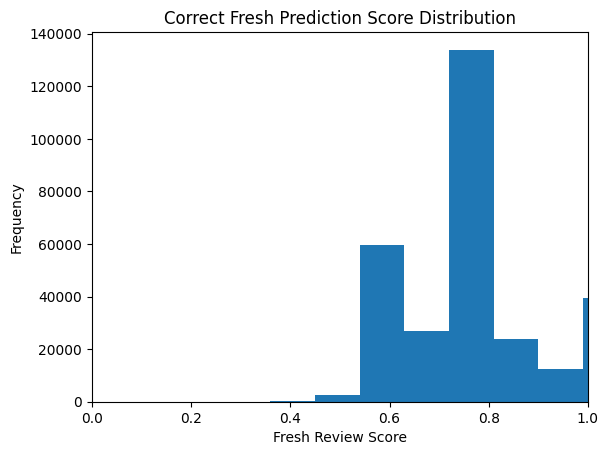

In [ ]:
plt.hist(fresh_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Fresh Review Score')
plt.ylabel('Frequency')
plt.title('Correct Fresh Prediction Score Distribution')
plt.show()

Mostly aligns with our expectations. All predictions appear to have a score greater than 0.5 on a 0-1 scale. How does it look for correct 'Rotten' predictions?

In [ ]:
rotten_review_scores = []
for i in range(len(train_preds_full)):
  if (train_preds_full[i]==0) & (train_preds_full[i]==y_train[i]):
    rotten_review_scores.append(new_score[i])

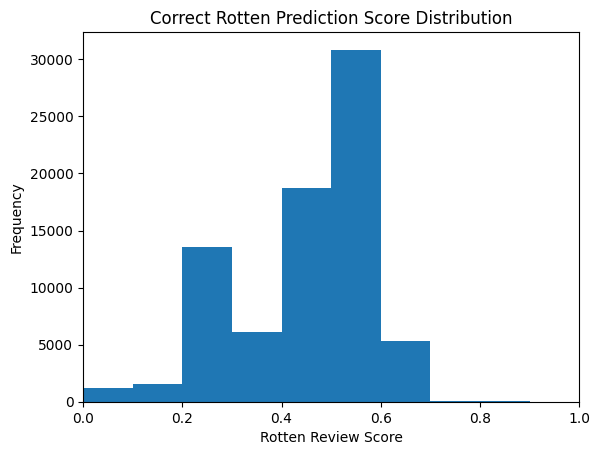

In [ ]:
plt.hist(rotten_review_scores, bins=10)
plt.xlim(0,1)
plt.xlabel('Rotten Review Score')
plt.ylabel('Frequency')
plt.title('Correct Rotten Prediction Score Distribution')
plt.show()


Looks almost like the image along the 0.5 mark of the x-axis. There does appear to be a lot of negative scores around 0.5 than anywhere else. It seems like the 'Rotten' reviews aren't as 'rotten' as the 'Fresh' reviews are 'fresh'.

What will the distribution of incorrect predictions look like?

In [ ]:
mix_review_scores = []
for i in range(len(train_preds_full)):
  if (train_preds_full[i]!=y_train[i]):
    mix_review_scores.append(new_score[i])

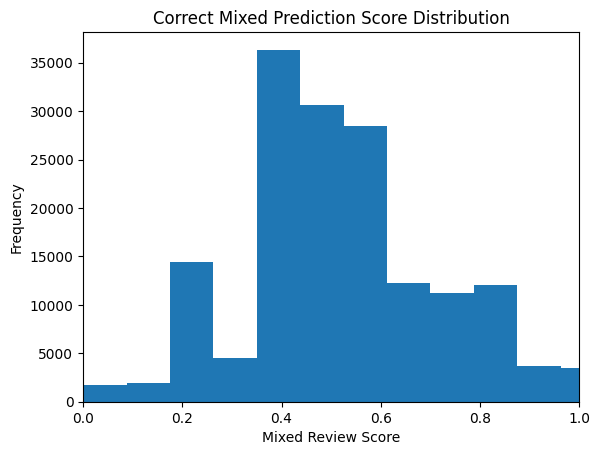

In [ ]:
plt.hist(mix_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Mixed Review Score')
plt.ylabel('Frequency')
plt.title('Correct Mixed Prediction Score Distribution')
plt.show()

Most incorrect predictions center around 0.5, but there is still high frequency at the higher and lower ends. We can do better!

In [ ]:
new_score_overall = []
for rs in reviews.review_score:
  if re.search('/', str(rs)):
    # print(rs)
    try:
      new_score_overall.append(float(re.search('(.*)/(.*)', rs).group(1))/float(re.search('(.*)/(.*)', rs).group(2)))
    except:
      new_score_overall.append(float(re.search('(.*)/(.*)', rs).group(1))/100.)
  elif re.search('A|B|C|D|F', str(rs)):
    new_score_overall.append(grades[rs[0]])
  else:
    new_score_overall.append(np.nan)


In [ ]:
preds = linear_model.predict(CountVec.transform([sent for sent in reviews.review_content]))
preds_full = (preds[:,0]>0.5).astype(int)

29467/29467 [==============================] - 52s 2ms/step


In [ ]:
y_actual = [1 if rt == 'Fresh' else 0 for rt in reviews.review_type]

In [ ]:
fresh_review_scores = []
for i in range(len(preds_full)):
  if (preds_full[i]==1) & (preds_full[i]==y_actual[i]):
    fresh_review_scores.append(new_score_overall[i])


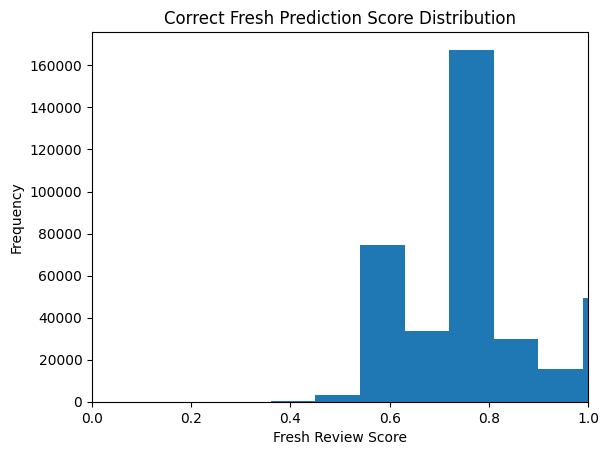

In [ ]:
plt.hist(fresh_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Fresh Review Score')
plt.ylabel('Frequency')
plt.title('Correct Fresh Prediction Score Distribution')
plt.show()


In [ ]:
rotten_review_scores = []
for i in range(len(preds_full)):
  if (preds_full[i]==0) & (preds_full[i]==y_actual[i]):
    rotten_review_scores.append(new_score_overall[i])

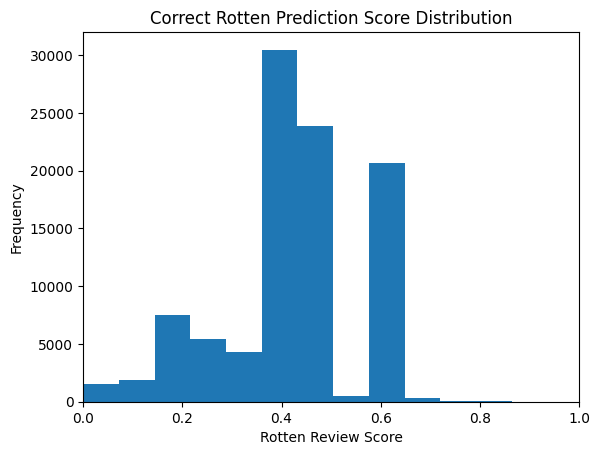

In [ ]:
plt.hist(rotten_review_scores, bins=25)
plt.xlim(0,1)
plt.xlabel('Rotten Review Score')
plt.ylabel('Frequency')
plt.title('Correct Rotten Prediction Score Distribution')
plt.show()


In [ ]:
mix_review_scores = []
for i in range(len(preds_full)):
  if (preds_full[i]!=y_actual[i]):
    mix_review_scores.append(new_score_overall[i])

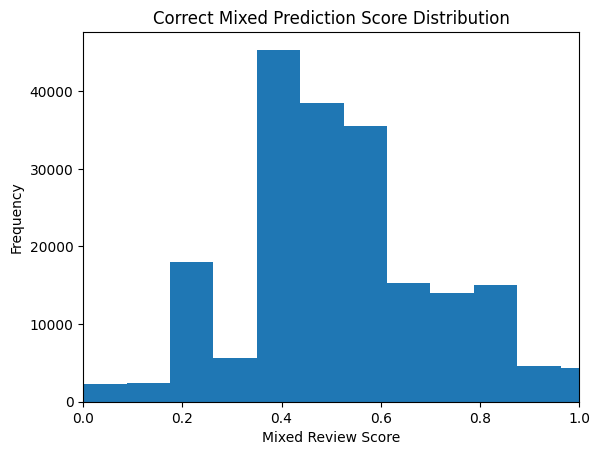

In [ ]:
plt.hist(mix_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Mixed Review Score')
plt.ylabel('Frequency')
plt.title('Correct Mixed Prediction Score Distribution')
plt.show()

How do the results change when we change our logistic regression to a Neural Network with 1 affine layer?

In [ ]:
keras.backend.clear_session()
deep_model = keras.Sequential([

    keras.layers.Dense(15, activation='relu'), #one affine layer of size 15
    keras.layers.Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5631 - accuracy: 0.7010 - val_loss: 0.5592 - val_accuracy: 0.7043
Epoch 2/15
23574/23574 [==============================] - 66s 3ms/step - loss: 0.5561 - accuracy: 0.7064 - val_loss: 0.5570 - val_accuracy: 0.7056
Epoch 3/15
23574/23574 [==============================] - 66s 3ms/step - loss: 0.5528 - accuracy: 0.7089 - val_loss: 0.5555 - val_accuracy: 0.7060
Epoch 4/15
23574/23574 [==============================] - 66s 3ms/step - loss: 0.5506 - accuracy: 0.7105 - val_loss: 0.5550 - val_accuracy: 0.7074
Epoch 5/15
23574/23574 [==============================] - 67s 3ms/step - loss: 0.5492 - accuracy: 0.7116 - val_loss: 0.5546 - val_accuracy: 0.7077
Epoch 6/15
23574/23574 [==============================] - 67s 3ms/step - loss: 0.5481 - accuracy: 0.7124 - val_loss: 0.5543 - val_accuracy: 0.7084
Epoch 7/15
23574/23574 [==============================] - 66s 3ms/step - loss: 0.5474 - accuracy: 0.7126 - val_loss: 0

In [ ]:
deep_model_test_preds = deep_model.predict(X_test)

2947/2947 [==============================] - 5s 2ms/step


In [ ]:
deep_model_test_preds_full = (deep_model_test_preds[:,0]>0.5).astype(int)

In [ ]:
deep_model_acc = accuracy(deep_model_test_preds_full, y_test)
deep_model_acc

0.708289144360073

It doesn't appear we get any gains from adding a deep layer to the network

In [ ]:
deep_preds = deep_model.predict(CountVec.transform([sent for sent in reviews.review_content]))
deep_preds_full = (deep_preds[:,0]>0.5).astype(int)

29467/29467 [==============================] - 55s 2ms/step


In [ ]:
fresh_review_scores = []
for i in range(len(deep_preds_full)):
  if (deep_preds_full[i]==1) & (deep_preds_full[i]==y_actual[i]):
    fresh_review_scores.append(new_score_overall[i])

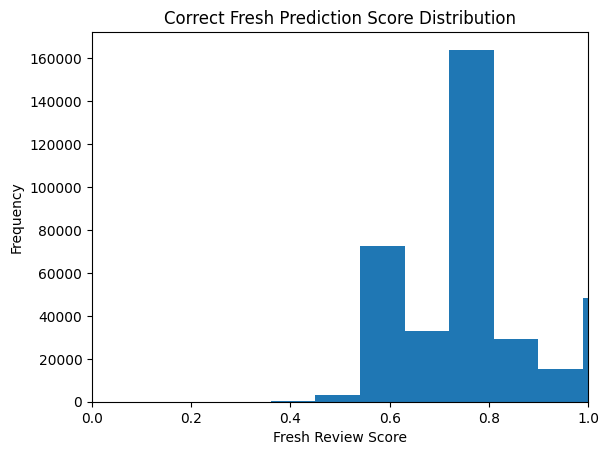

In [ ]:
plt.hist(fresh_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Fresh Review Score')
plt.ylabel('Frequency')
plt.title('Correct Fresh Prediction Score Distribution')
plt.show()


In [ ]:
rotten_review_scores = []
for i in range(len(deep_preds_full)):
  if (deep_preds_full[i]==0) & (deep_preds_full[i]==y_actual[i]):
    rotten_review_scores.append(new_score_overall[i])

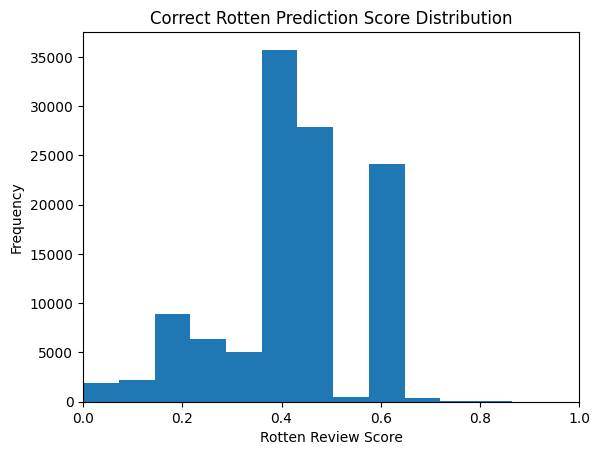

In [ ]:
plt.hist(rotten_review_scores, bins=25)
plt.xlim(0,1)
plt.xlabel('Rotten Review Score')
plt.ylabel('Frequency')
plt.title('Correct Rotten Prediction Score Distribution')
plt.show()


In [ ]:
mix_review_scores = []
for i in range(len(deep_preds_full)):
  if (deep_preds_full[i]!=y_actual[i]):
    mix_review_scores.append(new_score_overall[i])

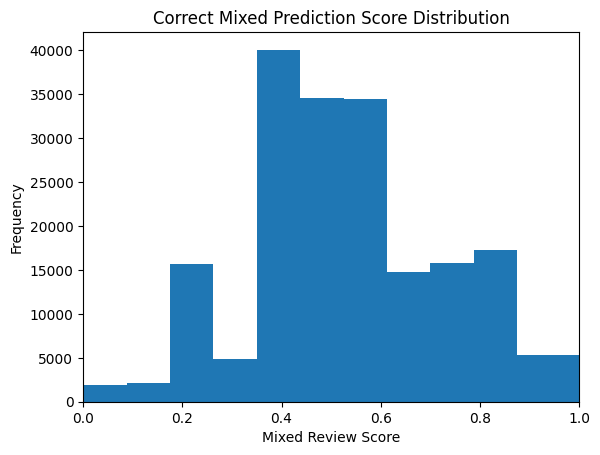

In [ ]:
plt.hist(mix_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Mixed Review Score')
plt.ylabel('Frequency')
plt.title('Correct Mixed Prediction Score Distribution')
plt.show()

What if we change our vocab size to 1000?

In [ ]:
CountVec3 = CountVectorizer(ngram_range=(1, 1),
                           stop_words='english',
                          max_features=1000) #vocab size up from 500

#transform
Count_data3 = CountVec3.fit_transform([sent for sent in reviews_train.review_content])

#create dataframe
cv_dataframe=pd.DataFrame(Count_data3.toarray(),columns=CountVec3.get_feature_names_out())
print(cv_dataframe)

        10  3d  90  ability  able  absolutely  achievement  act  acted  \
0        0   0   0        0     0           0            0    0      0   
1        0   0   0        0     0           0            0    0      0   
2        0   0   0        0     0           0            0    0      0   
3        0   0   0        0     0           0            0    0      0   
4        0   0   0        0     0           0            0    0      0   
...     ..  ..  ..      ...   ...         ...          ...  ...    ...   
754332   0   0   0        0     0           0            0    0      0   
754333   0   0   0        0     0           0            0    0      0   
754334   0   0   0        0     0           0            0    0      0   
754335   0   0   0        0     0           0            0    0      0   
754336   0   0   0        0     0           0            0    0      0   

        acting  ...  wouldn  writer  writing  written  wrong  year  years  \
0            0  ...       0       

In [ ]:
X_train = Count_data3.toarray()
X_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_val = CountVec3.transform([sent for sent in reviews_val.review_content])

In [ ]:
X_test = CountVec3.transform([sent for sent in reviews_test.review_content])

In [ ]:
linear_model = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid')
])

linear_model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])        

linear_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
23574/23574 [==============================] - 63s 3ms/step - loss: 0.5432 - accuracy: 0.7183 - val_loss: 0.5306 - val_accuracy: 0.7272
Epoch 2/15
23574/23574 [==============================] - 62s 3ms/step - loss: 0.5294 - accuracy: 0.7291 - val_loss: 0.5304 - val_accuracy: 0.7271
Epoch 3/15
23574/23574 [==============================] - 61s 3ms/step - loss: 0.5294 - accuracy: 0.7294 - val_loss: 0.5305 - val_accuracy: 0.7272
Epoch 4/15
23574/23574 [==============================] - 61s 3ms/step - loss: 0.5294 - accuracy: 0.7295 - val_loss: 0.5304 - val_accuracy: 0.7274
Epoch 5/15
23574/23574 [==============================] - 61s 3ms/step - loss: 0.5294 - accuracy: 0.7295 - val_loss: 0.5304 - val_accuracy: 0.7275
Epoch 6/15
23574/23574 [==============================] - 62s 3ms/step - loss: 0.5295 - accuracy: 0.7293 - val_loss: 0.5303 - val_accuracy: 0.7279
Epoch 7/15
23574/23574 [==============================] - 61s 3ms/step - loss: 0.5294 - accuracy: 0.7295 - val_loss: 0

Looks like our validation accuracy increases to <b>73%</b> with a vocab size of 1000.

In [ ]:
test_preds = linear_model.predict(X_test)
test_preds_full = (test_preds[:,0]>0.5).astype(int)
test_preds_full

2947/2947 [==============================] - 5s 2ms/step


array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
preds = linear_model.predict(CountVec3.transform([sent for sent in reviews.review_content]))
preds_full = (preds[:,0]>0.5).astype(int)

29467/29467 [==============================] - 53s 2ms/step


In [ ]:
fresh_review_scores = []
for i in range(len(preds_full)):
  if (preds_full[i]==1) & (preds_full[i]==y_actual[i]):
    fresh_review_scores.append(new_score_overall[i])

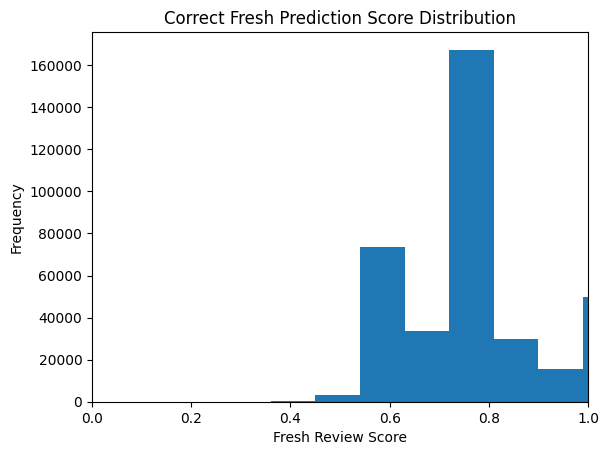

In [ ]:
plt.hist(fresh_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Fresh Review Score')
plt.ylabel('Frequency')
plt.title('Correct Fresh Prediction Score Distribution')
plt.show()

In [ ]:
rotten_review_scores = []
for i in range(len(preds_full)):
  if (preds_full[i]==0) & (preds_full[i]==y_actual[i]):
    rotten_review_scores.append(new_score_overall[i])

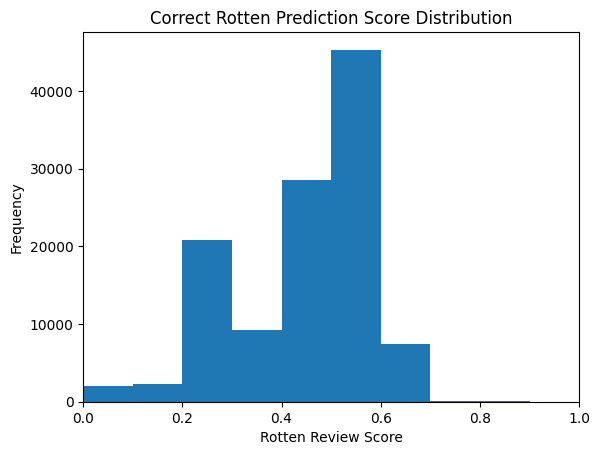

In [ ]:
plt.hist(rotten_review_scores, bins=10)
plt.xlim(0,1)
plt.xlabel('Rotten Review Score')
plt.ylabel('Frequency')
plt.title('Correct Rotten Prediction Score Distribution')
plt.show()


In [ ]:
mix_review_scores = []
for i in range(len(preds_full)):
  if (preds_full[i]!=y_actual[i]):
    mix_review_scores.append(new_score_overall[i])

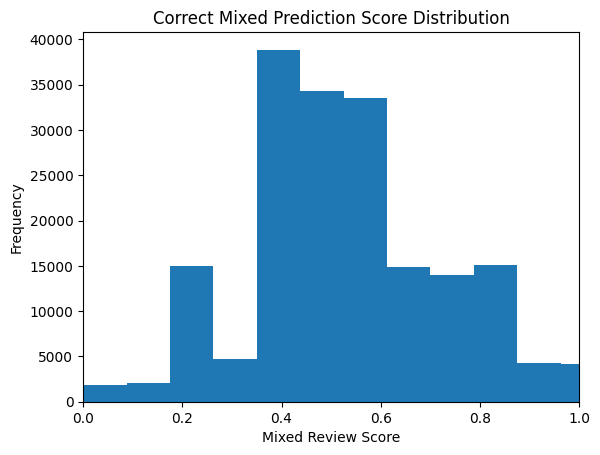

In [ ]:
plt.hist(mix_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Mixed Review Score')
plt.ylabel('Frequency')
plt.title('Correct Mixed Prediction Score Distribution')
plt.show()

The distribution looks slightly less spread out than our bag-of-words model with a vocab size of 500. But we still can do better!

In [ ]:
keras.backend.clear_session()
deep_model = keras.Sequential([

    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5314 - accuracy: 0.7256 - val_loss: 0.5263 - val_accuracy: 0.7282
Epoch 2/5
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5204 - accuracy: 0.7336 - val_loss: 0.5219 - val_accuracy: 0.7308
Epoch 3/5
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5156 - accuracy: 0.7378 - val_loss: 0.5213 - val_accuracy: 0.7317
Epoch 4/5
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5123 - accuracy: 0.7403 - val_loss: 0.5201 - val_accuracy: 0.7329
Epoch 5/5
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5101 - accuracy: 0.7420 - val_loss: 0.5211 - val_accuracy: 0.7323


In [ ]:
deep_model_preds = deep_model.predict(X_test)
deep_model_test_preds_full = (deep_model_test_preds[:,0]>0.5).astype(int)
accuracy(deep_model_test_preds_full, y_test)

2947/2947 [==============================] - 5s 2ms/step


0.708289144360073

The deeper model seems to be slightly overfit, with a similar accuracy to the 500 vocab size model.

In [ ]:
deep_preds = deep_model.predict(CountVec3.transform([sent for sent in reviews.review_content]))
deep_preds_full = (deep_preds[:,0]>0.5).astype(int)
accuracy(deep_preds_full, y_actual)

29467/29467 [==============================] - 54s 2ms/step


0.7436985707180135

In [ ]:
fresh_review_scores = []
for i in range(len(deep_preds_full)):
  if (deep_preds_full[i]==1) & (deep_preds_full[i]==y_actual[i]):
    fresh_review_scores.append(new_score_overall[i])

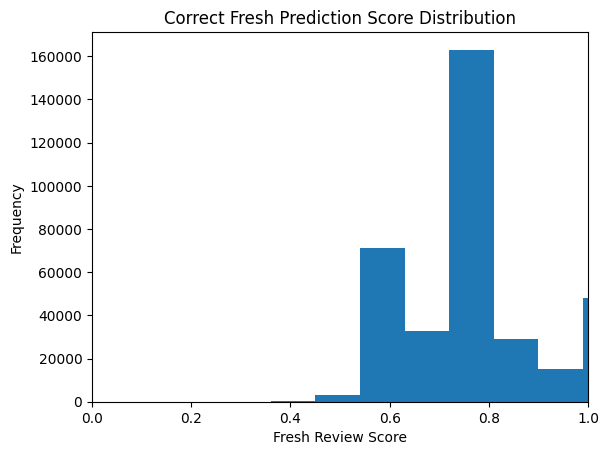

In [ ]:
plt.hist(fresh_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Fresh Review Score')
plt.ylabel('Frequency')
plt.title('Correct Fresh Prediction Score Distribution')
plt.show()

In [ ]:
rotten_review_scores = []
for i in range(len(deep_preds_full)):
  if (deep_preds_full[i]==0) & (deep_preds_full[i]==y_actual[i]):
    rotten_review_scores.append(new_score_overall[i])

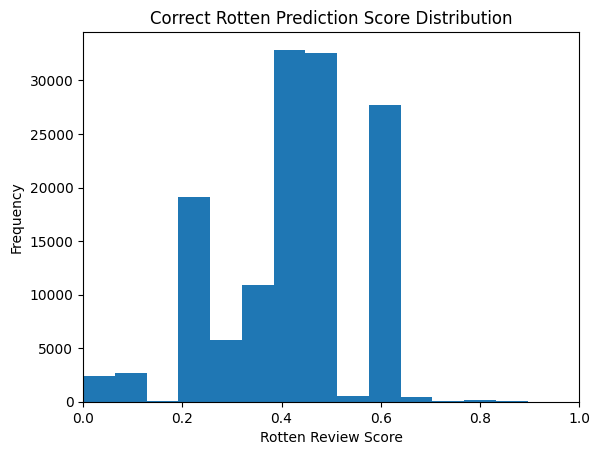

In [ ]:
plt.hist(rotten_review_scores, bins=25)
plt.xlim(0,1)
plt.xlabel('Rotten Review Score')
plt.ylabel('Frequency')
plt.title('Correct Rotten Prediction Score Distribution')
plt.show()

In [ ]:
mix_review_scores = []
for i in range(len(deep_preds_full)):
  if (deep_preds_full[i]!=y_actual[i]):
    mix_review_scores.append(new_score_overall[i])

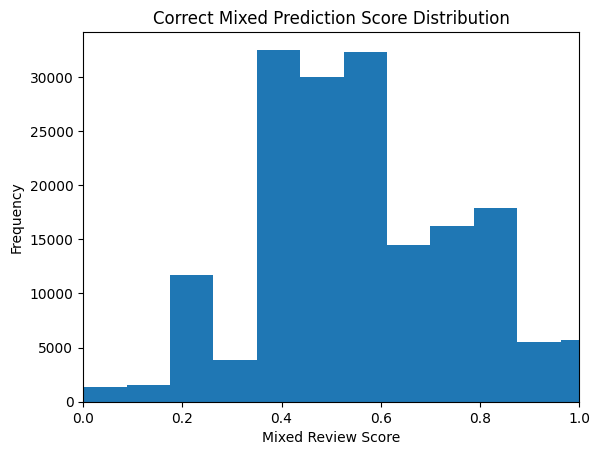

In [ ]:
plt.hist(mix_review_scores, bins=100)
plt.xlim(0,1)
plt.xlabel('Mixed Review Score')
plt.ylabel('Frequency')
plt.title('Correct Mixed Prediction Score Distribution')
plt.show()

Let's move away from bag-of-words models to more complex models.

In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.5 MB/s eta 0:00:00


In [ ]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [ ]:
def accuracy(preds, actual):
    return sum([p==a for p, a in zip(preds, actual)])/len(actual)

In [ ]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [ ]:
import pandas as pd
reviews = pd.read_csv('/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv')
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
reviews = reviews[(reviews.critic_name.notnull()) & (reviews.review_content.notnull())]
reviews.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name', 'review_content'], inplace=True)
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...


In [ ]:
reviews_train = reviews.sample(frac=0.8, random_state=1)
reviews_train

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
563579,m/mean_creek,Brad Slager,False,Film Threat,Fresh,3.5/5,2004-06-12,For a first time director to provoke such impr...
74436,m/1205380-crazies,Adam Graham,True,Detroit News,Rotten,C,2010-02-26,"If there's a message in all this, it's buried ..."
587192,m/moonlight_2016,Hanna B,False,Film Threat,Fresh,NaN,2019-08-06,It will forever live as one of the most profou...
1027199,m/the_wave_2020,Dave Canfield,False,ScreenAnarchy,Fresh,NaN,2019-12-05,"As movies featuring bad drug trips go, it rank..."
1102774,m/whiplash_2014,Elliott Noble,False,Sky Cinema,Fresh,5/5,2015-01-15,"Come the last beat, you'll probably be exhaust..."
...,...,...,...,...,...,...,...,...
184089,m/black_christmas,Mark Palermo,False,"The Coast (Halifax, Nova Scotia)",Rotten,NaN,2007-01-03,"Katie Cassidy, Michelle Trachtenberg, Mary Eli..."
81349,m/1217700-kick_ass,Anders Wotzke,False,Moviedex,Fresh,4.5/5,2010-03-19,Kick-Ass is what Spider-Man would have looked ...
539295,m/loveless_2018,Glenn Heath Jr.,False,San Diego CityBeat,Fresh,NaN,2018-08-20,"Being the blunt object that it is, Loveless in..."
624817,m/omar,Donald Clarke,False,Irish Times,Fresh,4/5,2014-05-30,The end result is a nerve-rattling entertainme...


In [ ]:
reviews_other = reviews[~reviews.index.isin(reviews_train.index)]
reviews_other

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
13,m/0814255,Joshua Tyler,False,CinemaBlend,Fresh,3/5,2010-02-11,The best thing you can say about Chris Columbu...
26,m/0814255,James Rocchi,True,MSN Movies,Fresh,3/5,2010-02-11,An attempt to steal some of Harry Potter's thu...
38,m/0814255,Michael Phillips,True,Chicago Tribune,Rotten,2/4,2010-02-11,Even with all its computer-generated fireballs...
41,m/0814255,Rich Cline,False,Shadows on the Wall,Fresh,3/5,2010-02-11,The Greek-gods premise lets the filmmakers ind...
...,...,...,...,...,...,...,...,...
1129975,m/zootopia,Danielle Solzman,False,Solzy at the Movies,Fresh,5/5,2020-09-24,Zootopia is the rare animated Disney film that...
1129984,m/zorba_the_greek,Wendy Michener,False,Maclean's Magazine,Rotten,NaN,2019-07-16,"As a whole the picture doesn't come off, partl..."
1130003,m/zulu,Will Heaven,True,Daily Telegraph (UK),Fresh,NaN,2017-07-10,"It may not be truthful - but, my God, the resu..."
1130004,m/zulu,Tony Sloman,False,Radio Times,Fresh,5/5,2017-07-10,The movie is a revelation.


In [ ]:
reviews_val = reviews_other.sample(frac=0.5, random_state=1)
reviews_test = reviews_other[~reviews_other.index.isin(reviews_val.index)]

In [ ]:
train_examples, train_labels = np.array([c for c in reviews_train.review_content]), np.array([1 if rt=='Fresh' else 0 for rt in reviews_train.review_type])
val_examples, val_labels = np.array([c for c in reviews_val.review_content]), np.array([1 if rt=='Fresh' else 0 for rt in reviews_val.review_type])
test_examples, test_labels = np.array([c for c in reviews_test.review_content]), np.array([1 if rt=='Fresh' else 0 for rt in reviews_test.review_type])

In [ ]:
MAX_SEQUENCE_LENGTH = 175

Let's use BERT embeddings with a neural architecture to see what improvements we get.

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
#@title BERT Tokenization of training and test data

train_examples_str = [x for x in train_examples]
test_examples_str = [x for x in test_examples]

bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

We'll start with a DAN model with BERT embeddings

In [ ]:
def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'


  dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')
  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings)
  dan_embeddings = dan_embedding_layer(dan_input_layer)
  dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                              name='averaging')(dan_embeddings)
  last_hidden_output = tf.keras.layers.Dense(hidden_dim,
                                             activation='relu',
                                             name='dan_hidden')(dan_avg_embeddings)
  last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  last_hidden_output = tf.keras.layers.Dense(hidden_dim,
                                             activation='relu',
                                             name='dan_hidden_2')(dan_avg_embeddings)
  last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)

  dan_classification = tf.keras.layers.Dense(1,
                                             activation='sigmoid',
                                             name='dan_classification')(last_hidden_output)
  dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
  dan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                       beta_1=0.9,
                                                       beta_2=0.999,
                                                       epsilon=1e-07,
                                                       amsgrad=False,
                                                       name='Adam'),
                    metrics='accuracy')

  return dan_model

In [ ]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

In [ ]:
test_input_data = [(x, y) for (x, y) in zip(list(test_input_ids), list(test_input_labels))]
test_input_data.sort(key = lambda x: x[1])
test_input_ids = np.array([x[0] for x in test_input_data])
test_labels = np.array([x[1] for x in test_input_data])

val_input_data = [(x, y) for (x, y) in zip(list(val_input_ids), list(val_input_labels))]
val_input_data.sort(key = lambda x: x[1])
val_input_ids = np.array([x[0] for x in val_input_data])
val_labels = np.array([x[1] for x in val_input_data])

In [ ]:
dan_model_shuffled = create_dan_model()

dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                                   sorted_training_labels,
                                   validation_data=(val_input_ids, val_labels),
                                   shuffle=True,
                                   batch_size=32,
                                   epochs=10)

Epoch 1/10
23574/23574 [==============================] - 68s 3ms/step - loss: 0.5523 - accuracy: 0.7084 - val_loss: 0.5391 - val_accuracy: 0.7186
Epoch 2/10
23574/23574 [==============================] - 65s 3ms/step - loss: 0.5286 - accuracy: 0.7290 - val_loss: 0.5267 - val_accuracy: 0.7282
Epoch 3/10
23574/23574 [==============================] - 65s 3ms/step - loss: 0.5253 - accuracy: 0.7312 - val_loss: 0.5184 - val_accuracy: 0.7365
Epoch 4/10
23574/23574 [==============================] - 64s 3ms/step - loss: 0.5225 - accuracy: 0.7333 - val_loss: 0.5159 - val_accuracy: 0.7376
Epoch 5/10
23574/23574 [==============================] - 65s 3ms/step - loss: 0.5206 - accuracy: 0.7339 - val_loss: 0.5168 - val_accuracy: 0.7350
Epoch 6/10
23574/23574 [==============================] - 65s 3ms/step - loss: 0.5191 - accuracy: 0.7357 - val_loss: 0.5136 - val_accuracy: 0.7381
Epoch 7/10
23574/23574 [==============================] - 64s 3ms/step - loss: 0.5184 - accuracy: 0.7358 - val_loss: 0

In [ ]:
dan_test_preds = dan_model_shuffled.predict(test_input_ids)

2947/2947 [==============================] - 4s 1ms/step


In [ ]:
dan_test_preds_full = (dan_test_preds[:,0]>0.5).astype(int)
dan_test_preds_full

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
def accuracy(preds, actual):
    return sum([p==a for p, a in zip(preds, actual)])/len(actual)

In [ ]:
accuracy(dan_test_preds_full, test_labels)

0.7403279175327705

Our test accuracy is up to <b>74%</b>. Let's try out a CNN now.

In [ ]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
# we define our hyperparameters
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [ ]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 175)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 175, 300)             1319460   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 173, 100)             90100     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 172, 100)             120100    ['embedding[0][0]']       

In [ ]:
cnn_history = cnn_model.fit(sorted_training_input_ids,
                            sorted_training_labels,
                            validation_data=(val_input_ids, val_labels),
                            shuffle=True,
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20
23574/23574 [==============================] - 122s 5ms/step - loss: 0.4804 - accuracy: 0.7608 - val_loss: 0.4422 - val_accuracy: 0.7848
Epoch 2/20
23574/23574 [==============================] - 110s 5ms/step - loss: 0.4447 - accuracy: 0.7847 - val_loss: 0.4282 - val_accuracy: 0.7977
Epoch 3/20
23574/23574 [==============================] - 111s 5ms/step - loss: 0.4295 - accuracy: 0.7945 - val_loss: 0.4219 - val_accuracy: 0.8025
Epoch 4/20
23574/23574 [==============================] - 110s 5ms/step - loss: 0.4184 - accuracy: 0.8014 - val_loss: 0.4134 - val_accuracy: 0.8064
Epoch 5/20
23574/23574 [==============================] - 111s 5ms/step - loss: 0.4094 - accuracy: 0.8064 - val_loss: 0.4091 - val_accuracy: 0.8073
Epoch 6/20
23574/23574 [==============================] - 111s 5ms/step - loss: 0.4025 - accuracy: 0.8105 - val_loss: 0.4086 - val_accuracy: 0.8077
Epoch 7/20
23574/23574 [==============================] - 110s 5ms/step - loss: 0.3950 - accuracy: 0.8149 - val_

In [ ]:
cnn_test_preds = cnn_model.predict(test_input_ids)
cnn_test_preds_full = (cnn_test_preds[:,0] > 0.5).astype(int)
accuracy(cnn_test_preds_full, test_labels)

2947/2947 [==============================] - 5s 2ms/step


0.8139714928095703

Our test accuracy is up to <b>81%</b> from the baseline test accuracy of <b>64%</b>. Big improvement! Can we do better with a BERT CNN model?

In [ ]:
# BERT Tokenization of training and test data

MAX_SEQUENCE_LENGTH = 175                 # set max_length of the input sequence

all_train_examples = [x for x in train_examples]
all_val_examples = [x for x in val_examples]
all_test_examples = [x for x in test_examples]

x_train = bert_tokenizer(all_train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_labels

x_val = bert_tokenizer(all_val_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_val = val_labels

x_test = bert_tokenizer(all_test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_labels

In [ ]:
def create_bert_cnn_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100,
                          learning_rate=0.00005):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_out[0])
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout)(conv_output)

    last_hidden_output = keras.layers.Dense(hidden_size, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[cnn_prediction])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_cnn_classification_model = create_bert_cnn_model()

In [ ]:
bert_cnn_classification_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 175)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 175)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 175)]                0         []                            
 tLayer)                                                                                      

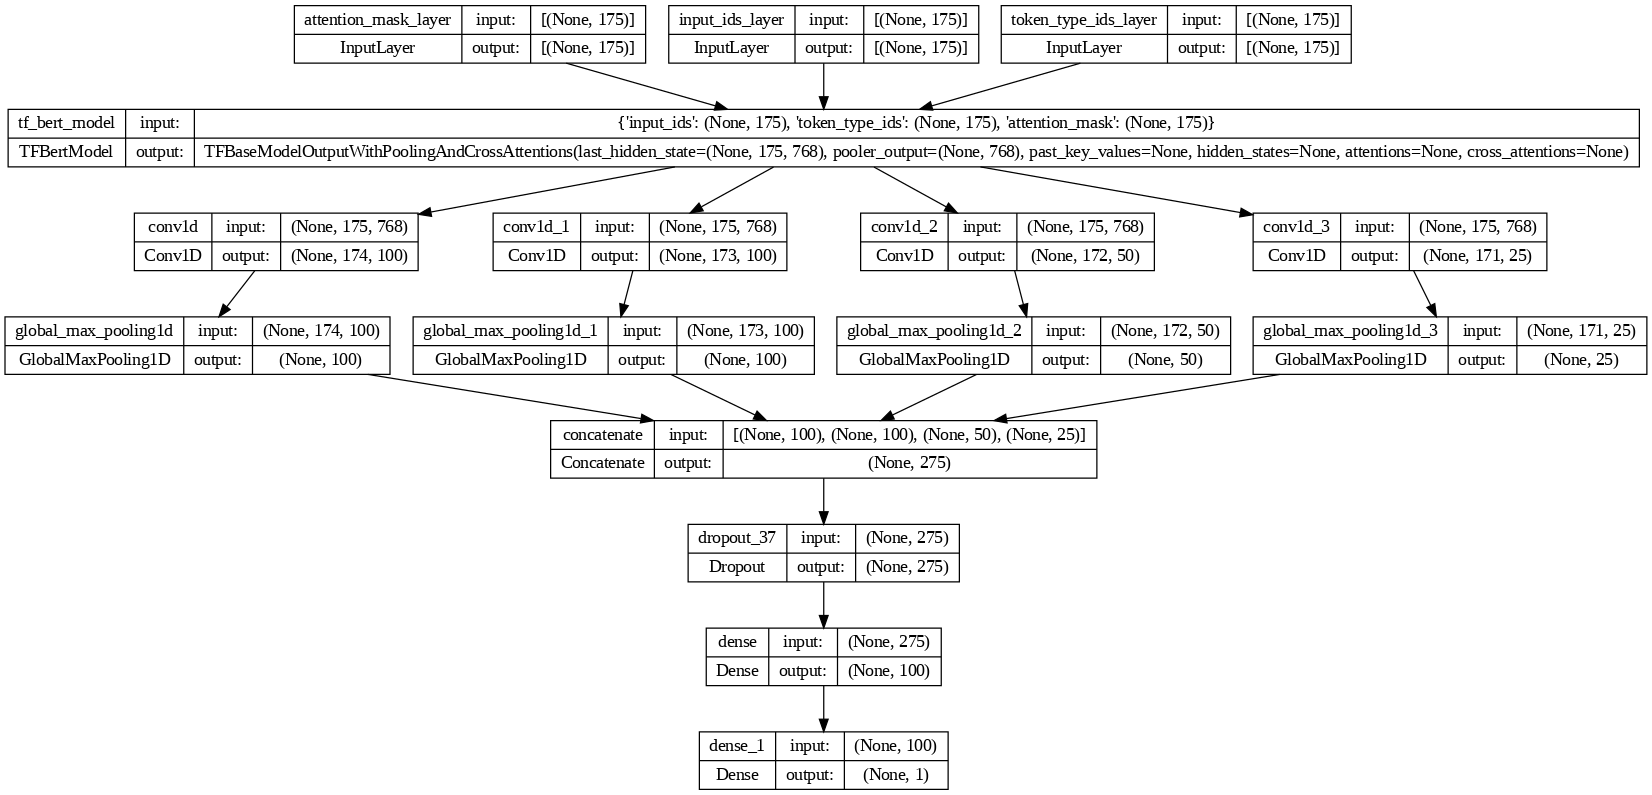

In [ ]:
keras.utils.plot_model(bert_cnn_classification_model, show_shapes=True, dpi=90)

In [ ]:
bert_cnn_classification_model_history = bert_cnn_classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3


23574/23574 [==============================] - 3418s 143ms/step - loss: 0.3162 - accuracy: 0.8631 - val_loss: 0.2854 - val_accuracy: 0.8751
Epoch 2/3
23574/23574 [==============================] - 3333s 141ms/step - loss: 0.2631 - accuracy: 0.8900 - val_loss: 0.2744 - val_accuracy: 0.8856
Epoch 3/3
23574/23574 [==============================] - 3328s 141ms/step - loss: 0.2363 - accuracy: 0.9028 - val_loss: 0.2704 - val_accuracy: 0.8859


In [ ]:
bert_cnn_preds = bert_cnn_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
bert_cnn_preds_full = (bert_cnn_preds[:,0]>0.5).astype(int)
accuracy(bert_cnn_preds_full, y_test)

2947/2947 [==============================] - 159s 53ms/step


0.8852394688838926

Test accuracy is up to <b>88%</b>! What do the review score distributions look like now?

In [ ]:
bert_cnn_classification_model.save('/content/drive/MyDrive/my_bert_cnn_classification_model')

In [ ]:
reviews_test.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
26,m/0814255,James Rocchi,True,MSN Movies,Fresh,3/5,2010-02-11,An attempt to steal some of Harry Potter's thu...
44,m/0814255,Peter Debruge,True,Variety,Fresh,NaN,2010-02-11,Action movies of this scale often start off st...
64,m/0814255,Willie Waffle,False,WaffleMovies.com,Rotten,1.5/4,2010-02-12,While winning the award for longest movie titl...
76,m/0814255,Helen O'Hara,False,Empire Magazine,Fresh,3/5,2010-02-12,It's apparent that Potter may at last have a w...


In [ ]:
len(bert_cnn_preds_full), len(reviews_test)

(94292, 94292)

In [ ]:
grades = {'A': 1., 'B': .8, 'C': .6, 'D': .4, 'F': .2}
grades

{'A': 1.0, 'B': 0.8, 'C': 0.6, 'D': 0.4, 'F': 0.2}

In [ ]:
new_score = []
for rs in reviews_test.review_score:
  if re.search('/', str(rs)):
    # print(rs)
    try:
      new_score.append(float(re.search('(.*)/(.*)', rs).group(1))/float(re.search('(.*)/(.*)', rs).group(2)))
    except:
      new_score.append(float(re.search('(.*)/(.*)', rs).group(1))/100.)
  elif re.search('A|B|C|D|F', str(rs)):
    new_score.append(grades[rs[0]])
  else:
    new_score.append(np.nan)



In [ ]:
fresh_review_scores = []
for i in range(len(bert_cnn_preds_full)):
  if (bert_cnn_preds_full[i]==1) & (bert_cnn_preds_full[i]==y_test[i]):
    fresh_review_scores.append(new_score[i])

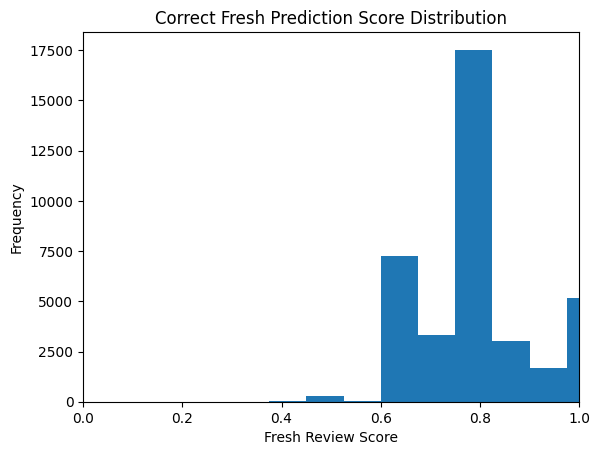

In [ ]:
plt.hist(fresh_review_scores, bins=15)
plt.xlim(0,1)
plt.xlabel('Fresh Review Score')
plt.ylabel('Frequency')
plt.title('Correct Fresh Prediction Score Distribution')
plt.show()


In [ ]:
rotten_review_scores = []
for i in range(len(bert_cnn_preds_full)):
  if (bert_cnn_preds_full[i]==0) & (bert_cnn_preds_full[i]==y_test[i]):
    rotten_review_scores.append(new_score[i])

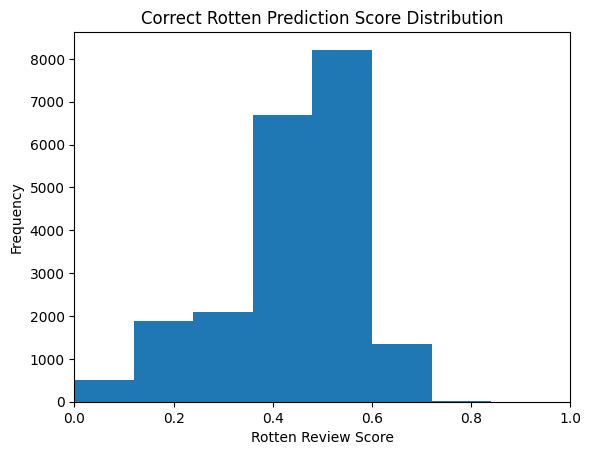

In [ ]:
plt.hist(rotten_review_scores, bins=15)
plt.xlim(0,1)
plt.xlabel('Rotten Review Score')
plt.ylabel('Frequency')
plt.title('Correct Rotten Prediction Score Distribution')
plt.show()


In [ ]:
mixed_review_scores = []
for i in range(len(bert_cnn_preds_full)):
  if (bert_cnn_preds_full[i]!=y_test[i]):
    mixed_review_scores.append(new_score[i])

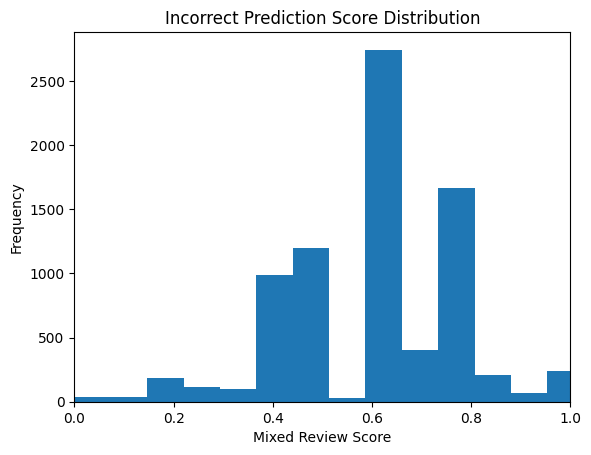

In [ ]:
plt.hist(mixed_review_scores, bins=15)
plt.xlim(0,1)
plt.xlabel('Mixed Review Score')
plt.ylabel('Frequency')
plt.title('Incorrect Prediction Score Distribution')
plt.show()

Incorrect predictions are now much less frequent and spread out. It appears most incorrect predictions are "understandable", meaning they are on the cusp of "Fresh" or "Rotten". We'll use this sentiment model moving forward!

# Sentiment Style Transfer

We'll now see if we can translate positive reviews into negative reviews, using encoder-decoder models. We'll use our BERT CNN model to see if the translations correctly capture negative sentiment.

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 13.2 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv')
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
len(reviews[reviews.critic_name=='Roger Ebert'])

6417

In [ ]:
reviews = reviews[(reviews.critic_name.notnull()) & (reviews.review_content.notnull())]
reviews.drop_duplicates(subset=['critic_name', 'rotten_tomatoes_link'], inplace=True)
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...


In [ ]:
vocab = [rc.split(' ') for rc in reviews.review_content]

In [ ]:
#see the number of unique words in the dataset's reviews
new_vocab = []
for w in vocab:
  for i in w:
    new_vocab.append(i)
len(set(new_vocab))

480476

In [ ]:
#join reviews that are 'Fresh' to 'Rotten' reviews
reviews_left = reviews.copy()
reviews_left = reviews_left[reviews_left.review_type=='Fresh']
reviews_left.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ..."
8,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative"


In [ ]:
reviews_right = reviews.copy()
reviews_right = reviews_right[reviews_right.review_type=='Rotten']
reviews_right.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
11,m/0814255,Roger Moore,True,Orlando Sentinel,Rotten,2/4,2010-02-10,"For what it is and for whom it is intended, it..."
12,m/0814255,David Jenkins,True,Time Out,Rotten,2/5,2010-02-10,Chris Columbus returns to his comfort zone for...


In [ ]:
#join 'Fresh' reviews to 'Rotten' reviews of the same movie
reviews_translate = reviews_left.set_index('rotten_tomatoes_link').join(reviews_right.set_index('rotten_tomatoes_link'), how='inner', rsuffix='_ebert')
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Brent Goldman,False,Film Inquiry,Rotten,NaN,2019-05-09,Plus One is a by-the-book romantic comedy. It ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Peter Sobczynski,False,eFilmCritic.com,Rotten,NaN,2019-06-14,Plus One is ultimately harmless and forgettabl...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Todd Jorgenson,False,Cinemalogue,Rotten,NaN,2019-06-14,Millennial angst clouds romantic judgment for ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Frank Swietek,False,One Guy's Opinion,Rotten,C,2019-06-14,"A moderately amusing romcom but, in the end, n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zulu,Joan Didion,False,Vogue,Fresh,NaN,2020-03-16,A rousing reconstruction of the 1879 Battle of...,Louis Proyect,False,rec.arts.movies.reviews,Rotten,NaN,2002-02-19,Its failure to present any kind of historical ...
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Brent McKnight,False,The Last Thing I See,Rotten,C,2020-07-09,Rides the line between being a pure artifact o...


In [ ]:
#critic names shouldn't be the same, but just to make sure
reviews_translate = reviews_translate[reviews_translate.critic_name!=reviews_translate.critic_name_ebert]
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Brent Goldman,False,Film Inquiry,Rotten,NaN,2019-05-09,Plus One is a by-the-book romantic comedy. It ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Peter Sobczynski,False,eFilmCritic.com,Rotten,NaN,2019-06-14,Plus One is ultimately harmless and forgettabl...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Todd Jorgenson,False,Cinemalogue,Rotten,NaN,2019-06-14,Millennial angst clouds romantic judgment for ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Frank Swietek,False,One Guy's Opinion,Rotten,C,2019-06-14,"A moderately amusing romcom but, in the end, n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zulu,Joan Didion,False,Vogue,Fresh,NaN,2020-03-16,A rousing reconstruction of the 1879 Battle of...,Louis Proyect,False,rec.arts.movies.reviews,Rotten,NaN,2002-02-19,Its failure to present any kind of historical ...
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Brent McKnight,False,The Last Thing I See,Rotten,C,2020-07-09,Rides the line between being a pure artifact o...


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate = reviews_translate.sample(frac=1, random_state=1) #randomly sort the data
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
20220663,m/wild_2014,John Powers,False,Vogue,Fresh,NaN,2017-04-26,"Not surprisingly, Witherspoon nails it with a ...",Avaryl Halley,False,Movie Bitches,Rotten,NaN,2020-05-27,Nothing happened at all.
5601959,m/domino,Michael Dequina,False,TheMovieReport.com,Fresh,3/4,2006-07-26,Sometimes sound and fury can be quite somethin...,Cherryl Dawson and Leigh Ann Palone,False,TheMovieChicks.com,Rotten,2.5/5,2005-10-17,The first part of the film holds your attentio...
17330938,m/the_hunt_2013,Todd Jorgenson,False,Cinemalogue,Fresh,NaN,2013-07-22,Although the scenario is exaggerated for drama...,Jon Frosch,True,Village Voice,Rotten,NaN,2013-07-10,There's nothing worthy of love or hate in this...
15043254,m/spiderman,Scott Nash,False,Three Movie Buffs,Fresh,3.5/4,2005-09-30,"At its best, it's action packed fantasy, groun...",Manohla Dargis,False,L.A. Weekly,Rotten,NaN,2002-06-01,"Introduced in 1962, the original superhero hel..."
897110,m/1193230-state_of_play,Robin Clifford,False,Reeling Reviews,Fresh,B,2009-04-16,...the kind of thriller that begs to surprise ...,Kimberly Gadette,False,Indie Movies Online,Rotten,5/10,2009-04-17,The attempt to examine a decaying print world ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13419401,m/ready_or_not_2019,Mark Kermode,False,Kermode & Mayo's Film Review,Fresh,NaN,2019-10-03,Laugh-out-loud moments with slight revulsion.....,Robert Ham,False,"The Stranger (Seattle, WA)",Rotten,NaN,2019-08-22,"As Ready or Not rolls on, it all becomes much ..."
491263,m/1108704-planet_of_the_apes,David Nusair,False,Reel Film Reviews,Fresh,3/4,2003-08-01,...one of the most entertaining check-your-bra...,David Elliott,False,San Diego Union-Tribune,Rotten,NaN,2001-07-27,"Though often swank, it might be too harsh and ..."
12325960,m/omen,Tom Long,True,Detroit News,Fresh,B-,2006-06-06,Future generations can only hope something so ...,Jeff Vice,False,Deseret News (Salt Lake City),Rotten,2/4,2006-06-06,You can file the remake of The Omen under 'Unn...
6762380,m/freeheld_2015,Alan Scherstuhl,True,Village Voice,Fresh,NaN,2015-09-29,"It's a sharp-enough political drama, building ...",Andrew Chan,False,Film Comment Magazine,Rotten,NaN,2015-09-14,Only a country where marriage equality is a fo...


In [ ]:
#only use one instance of a given movie/critic combo
reviews_translate.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name'], inplace=True)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
20220663,m/wild_2014,John Powers,False,Vogue,Fresh,NaN,2017-04-26,"Not surprisingly, Witherspoon nails it with a ...",Avaryl Halley,False,Movie Bitches,Rotten,NaN,2020-05-27,Nothing happened at all.
5601959,m/domino,Michael Dequina,False,TheMovieReport.com,Fresh,3/4,2006-07-26,Sometimes sound and fury can be quite somethin...,Cherryl Dawson and Leigh Ann Palone,False,TheMovieChicks.com,Rotten,2.5/5,2005-10-17,The first part of the film holds your attentio...
17330938,m/the_hunt_2013,Todd Jorgenson,False,Cinemalogue,Fresh,NaN,2013-07-22,Although the scenario is exaggerated for drama...,Jon Frosch,True,Village Voice,Rotten,NaN,2013-07-10,There's nothing worthy of love or hate in this...
15043254,m/spiderman,Scott Nash,False,Three Movie Buffs,Fresh,3.5/4,2005-09-30,"At its best, it's action packed fantasy, groun...",Manohla Dargis,False,L.A. Weekly,Rotten,NaN,2002-06-01,"Introduced in 1962, the original superhero hel..."
897110,m/1193230-state_of_play,Robin Clifford,False,Reeling Reviews,Fresh,B,2009-04-16,...the kind of thriller that begs to surprise ...,Kimberly Gadette,False,Indie Movies Online,Rotten,5/10,2009-04-17,The attempt to examine a decaying print world ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182844,m/american_graffiti,R.L. Shaffer,False,IGN DVD,Fresh,9/10,2012-01-29,American Graffiti is a music-infused tone poem...,Kevin Carr,False,7M Pictures,Rotten,2/5,2013-09-05,Anyone who has spent their teenage years cruis...
7548342,m/guru,Raam Tarat,False,Future Movies UK,Fresh,4.5/5,2017-10-30,"Mani Ratnam is a master film-maker, in fact, h...",Namrata Joshi,False,Outlook,Rotten,2/4,2019-01-23,"The gait, the mannerisms, the voice, the dicti..."
7469758,m/gregorys_girl,Roger Moore,False,Movie Nation,Fresh,3.5/4,2020-04-05,"""Gregory's Girl"" was adorably ""random"" before ...",Janet Branagan,False,Apollo Guide,Rotten,66/100,2002-03-11,What could have been a charming film about pin...
15349890,m/steal_a_pencil_for_me,Joe Leydon,True,Variety,Fresh,NaN,2007-10-31,Describing what Steal a Pencil for Me is about...,Rob Humanick,False,Slant Magazine,Rotten,2/4,2007-11-09,"A misguided documentary that mistakes cutesy, ..."


In [ ]:
#dedupe further to include a unique movie only once. reviews included are random
reviews_translate.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name_ebert'], inplace=True)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
20220663,m/wild_2014,John Powers,False,Vogue,Fresh,NaN,2017-04-26,"Not surprisingly, Witherspoon nails it with a ...",Avaryl Halley,False,Movie Bitches,Rotten,NaN,2020-05-27,Nothing happened at all.
5601959,m/domino,Michael Dequina,False,TheMovieReport.com,Fresh,3/4,2006-07-26,Sometimes sound and fury can be quite somethin...,Cherryl Dawson and Leigh Ann Palone,False,TheMovieChicks.com,Rotten,2.5/5,2005-10-17,The first part of the film holds your attentio...
17330938,m/the_hunt_2013,Todd Jorgenson,False,Cinemalogue,Fresh,NaN,2013-07-22,Although the scenario is exaggerated for drama...,Jon Frosch,True,Village Voice,Rotten,NaN,2013-07-10,There's nothing worthy of love or hate in this...
15043254,m/spiderman,Scott Nash,False,Three Movie Buffs,Fresh,3.5/4,2005-09-30,"At its best, it's action packed fantasy, groun...",Manohla Dargis,False,L.A. Weekly,Rotten,NaN,2002-06-01,"Introduced in 1962, the original superhero hel..."
897110,m/1193230-state_of_play,Robin Clifford,False,Reeling Reviews,Fresh,B,2009-04-16,...the kind of thriller that begs to surprise ...,Kimberly Gadette,False,Indie Movies Online,Rotten,5/10,2009-04-17,The attempt to examine a decaying print world ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560202,m/1120975-shaft,Cole Smithey,False,ColeSmithey.com,Fresh,3/5,2007-03-11,Great little B-movie horror with Naomi Watts s...,Felix Vasquez Jr.,False,Cinema Crazed,Rotten,NaN,2009-05-07,"Only thing worse than a bad horror film, is a ..."
8690936,m/inkwell,Roger Ebert,True,Chicago Sun-Times,Fresh,3/4,2000-01-01,"Rich is still learning as a filmmaker, and he ...",Emanuel Levy,False,EmanuelLevy.Com,Rotten,C-,2007-08-08,"Messy and tawdry, this ambitious film proved t..."
15975328,m/terror_tract,Felix Vasquez Jr.,False,Cinema Crazed,Fresh,NaN,2009-04-29,A solid anthology horror film that opts more f...,David Nusair,False,Reel Film Reviews,Rotten,1/4,2003-05-10,"Terror Tract might be worth a cheap rental, bu..."
11721813,m/mr_jones,Roger Ebert,True,Chicago Sun-Times,Fresh,3/4,2000-01-01,"The movie is worth seeing, for Gere's transiti...",Chris Hicks,False,Deseret News (Salt Lake City),Rotten,NaN,2000-01-01,This glossy Hollywood romantic melodrama is a ...


In [ ]:
#set up 80/10/10 train/val/test split
reviews_translate.reset_index(inplace=True)
reviews_translate_train = reviews_translate.sample(frac=0.8, random_state=1)
reviews_translate_other = reviews_translate[~reviews_translate.index.isin(reviews_translate_train.index)]
reviews_translate_val = reviews_translate_other.sample(frac=0.5, random_state=1)
reviews_translate_test = reviews_translate_other[~reviews_translate_other.index.isin(reviews_translate_val.index)]
reviews_translate_train

,index,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
21556,11888764,m/nanny_mcphee,Kevin Carr,False,7M Pictures,Fresh,3/5,2012-08-01,It's more of a kids' film than a grown-up's mo...,Cole Smithey,False,ColeSmithey.com,Rotten,C-,2006-01-25,The movie is hampered by production designer M...
180396,6732037,m/freddys_dead_the_final_nightmare,Caffeinated Clint,False,Moviehole,Fresh,3/5,2002-09-17,"Fun, but not the best way for Freddy to crumble",Marc Savlov,False,Austin Chronicle,Rotten,0/5,2000-01-01,Hardly a fitting capstone to one of the genre'...
14124,8274253,m/humpday,Kent Turner,False,Film-Forward.com,Fresh,3/5,2009-07-09,Can director Lynn Shelton sustain enough inter...,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Rotten,C+,2009-10-24,It says very little about anything though prom...
21181,10804052,m/majestic,William Arnold,False,Seattle Post-Intelligencer,Fresh,B+,2001-12-20,[Carrey's] natural charisma carries the movie ...,Dan Lybarger,False,Lawrence Journal-World,Rotten,2/4,2001-12-20,"Sadly, because credibility takes a back seat t..."
106599,18399920,m/the_spongebob_movie_sponge_out_of_water,Jake Wilson,True,Sydney Morning Herald,Fresh,3.5/5,2015-03-25,"It's a simple premise with proven appeal, givi...",Michael Rechtshaffen,True,Hollywood Reporter,Rotten,NaN,2015-02-01,"While it has plenty of zany moments, SpongeBob..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170307,18897284,m/to_save_a_life,Richard Propes,False,TheIndependentCritic.com,Fresh,2.5/4,2020-09-26,It does accomplish its mission of presenting a...,Melissa Anderson,True,Village Voice,Rotten,NaN,2010-01-19,To Save a Life is about as subtle as this clos...
97891,12257858,m/oceans_thirteen,Jeffrey Westhoff,False,"Northwest Herald (Crystal Lake, IL)",Fresh,3/4,2007-06-16,"The cast and crew are having a lark, and the m...",Frank Swietek,False,One Guy's Opinion,Rotten,C+,2007-06-05,Bright and glitzy but ultimately ephemeral and...
168006,5554559,m/do_you_trust_this_computer,Noel Murray,True,Los Angeles Times,Fresh,NaN,2018-04-06,"""Do You Trust This Computer?"" covers the major...",Daphne Howland,True,Village Voice,Rotten,NaN,2018-08-15,The doc never goes much deeper than the inform...
87017,3770733,m/brideshead_revisited,Hank Sartin,True,Time Out,Fresh,3/6,2008-07-24,If you can let go of your memories of the nove...,Peter Sobczynski,False,eFilmCritic.com,Rotten,2/5,2008-07-24,In trying to wrestle the story into a workable...


In [ ]:
#hyperparameter definitions
BATCH_SIZE = 64
EPOCHS = 15
MAX_SEQUENCE_LENGTH = 125

#The size of our fresh and rotten language vocabularies
ORG_VOCAB_SIZE = 30000
MOD_VOCAB_SIZE = 30000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [ ]:
train_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_train.review_content, reviews_translate_train.review_content_ebert)]
test_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_test.review_content, reviews_translate_test.review_content_ebert)]
val_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_val.review_content, reviews_translate_val.review_content_ebert)]

In [ ]:
#look at some random examples
import random
for _ in range(5):
    print(random.choice(train_pairs))

('Non-stop action sequel holds its own against predecessors.', 'Might pass muster as a serviceable, if infuriatingly coy, Bourne spin-off if the lead were not so woefully miscast.')
('In this time of intensifying, acrimonious racial division, maybe what we could all use is an old-fashioned courtroom drama that extols the virtues of justice and equality.', 'Marshall would have benefited from a much more serious tone and approach, not shying away from the true brutality of the time.')
("Just because something has been done before doesn't mean it can't be done again, and well. 'The Express' is formula-driven entertainment of an uncommonly high order.", "Tries to be another 'Brian's Song' but doesn't quite make it")
("An HBO special dragged kicking and screaming to (barely) feature length, it's a riot... but probably shouldn't be in theaters.", 'While she does have her funny moments, her insensitive persona is simply not interesting enough to warrant a feature film.')
('Written and directe

In [ ]:
import keras_nlp
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [ ]:
#create tokenizations and subword models for given vocabularies
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# Positive
org_samples = [text_pair[0] for text_pair in train_pairs]
org_vocab = train_word_piece(org_samples, ORG_VOCAB_SIZE, reserved_tokens)

# Negative
mod_samples = [text_pair[1] for text_pair in train_pairs]
mod_vocab = train_word_piece(mod_samples, MOD_VOCAB_SIZE, reserved_tokens)

In [ ]:
print("Fresh Tokens: ", org_vocab[100:110])
print("Rotten Tokens: ", mod_vocab[100:110])

Fresh Tokens:  ['Ó', 'Ô', 'Õ', 'Ö', 'Ø', 'Ü', 'à', 'á', 'â', 'ã']
Rotten Tokens:  ['Ã', 'Å', 'È', 'É', 'Ó', 'Ô', 'Ö', 'Ø', 'Ü', 'Þ']


In [ ]:
mod_vocab[500:550]

['##r',
 'mostly',
 'tone',
 'along',
 'book',
 'subject',
 'plays',
 'didn',
 'flat',
 'star',
 'part',
 'true',
 'cinematic',
 'else',
 'Like',
 'Review',
 'give',
 'One',
 'worth',
 'tries',
 'comic',
 '##t',
 'show',
 'years',
 'sort',
 'At',
 'once',
 'effort',
 'probably',
 'We',
 'looks',
 'three',
 'level',
 'familiar',
 'again',
 'kids',
 'entertaining',
 'documentary',
 'When',
 'result',
 'second',
 'franchise',
 'hours',
 'act',
 'keep',
 'looking',
 '##es',
 'direction',
 'TV',
 'writer']

In [ ]:
mod_vocab[200:250]

['It',
 'not',
 'you',
 'more',
 'are',
 'like',
 'than',
 'by',
 '##s',
 'have',
 'at',
 'all',
 'from',
 'one',
 'about',
 'so',
 'or',
 'has',
 'too',
 'his',
 'much',
 'up',
 'story',
 'just',
 'out',
 'can',
 'into',
 'what',
 'This',
 'no',
 'there',
 'good',
 'only',
 'doesn',
 'was',
 'he',
 'some',
 'they',
 'who',
 'if',
 'even',
 'time',
 'never',
 'little',
 'make',
 'been',
 'characters',
 'which',
 'comedy',
 'enough']

In [ ]:
org_vocab[200:250]

['so',
 'can',
 'most',
 'who',
 'out',
 'some',
 'or',
 'will',
 'into',
 'This',
 'well',
 'just',
 'if',
 'what',
 'fun',
 'comedy',
 'time',
 'much',
 'action',
 'best',
 'even',
 'there',
 'enough',
 'he',
 'make',
 'their',
 'way',
 'funny',
 'which',
 'too',
 'great',
 'makes',
 'very',
 'may',
 'your',
 'still',
 'entertaining',
 'characters',
 'we',
 'performances',
 'little',
 'performance',
 'when',
 'director',
 'does',
 'they',
 'no',
 'was',
 'doesn',
 'But']

In [ ]:
org_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=org_vocab, lowercase=True
)
mod_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=mod_vocab, lowercase=True
)

In [ ]:
org_input_ex = train_pairs[0][0]
org_tokens_ex = org_tokenizer.tokenize(org_input_ex)
print("Fresh sentence: ", org_input_ex)
print("Tokens: ", org_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    org_tokenizer.detokenize(org_tokens_ex),
)

print()

mod_input_ex = train_pairs[0][1]
mod_tokens_ex = mod_tokenizer.tokenize(mod_input_ex)
print("Rotten sentence: ", mod_input_ex)
print("Tokens: ", mod_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    mod_tokenizer.detokenize(mod_tokens_ex),
)

Fresh sentence:  It's more of a kids' film than a grown-up's movie, with a good message at its heart.
Tokens:  tf.Tensor(
[ 165   10   85  187  162   67  460   10  172  191   67 1385   16  199
   10   85  176   15  168   67  198  625  185  174  309   17], shape=(26,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b"it ' s more of a kids ' film than a grown - up ' s movie , with a good message at its heart .", shape=(), dtype=string)

Rotten sentence:  The movie is hampered by production designer Michael Howell's garish neon color palate contrasted against clownish costumes by Nic Ede...
Tokens:  tf.Tensor(
[  180   194   184  3596   207   588  5530    80 11037 10707   298  6184
    10    86  4867  8269  2330 19332  4858   293   750 22019  2581   207
 12991  2433 11994   403    17    17    17], shape=(31,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b"the movie is hampered by production designer michael howell ' s garish neon color palate contrasted against 

In [ ]:
def preprocess_batch(org, mod):
    batch_size = tf.shape(mod)[0]

    org = org_tokenizer(org)
    mod = mod_tokenizer(mod)

    org_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=org_tokenizer.token_to_id("[PAD]"),
    )
    org = org_start_end_packer(org)

    mod_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=mod_tokenizer.token_to_id("[START]"),
        end_value=mod_tokenizer.token_to_id("[END]"),
        pad_value=mod_tokenizer.token_to_id("[PAD]"),
    )
    mod = mod_start_end_packer(mod)

    return (
        {
            "encoder_inputs": org,
            "decoder_inputs": mod[:, :-1],
        },
        mod[:, 1:],
    )


def make_dataset(pairs):
    org_texts, mod_texts = zip(*pairs)
    org_texts = list(org_texts)
    mod_texts = list(mod_texts)
    dataset = tf.data.Dataset.from_tensor_slices((org_texts, mod_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

#make the training data
train_ds = make_dataset(train_pairs)

#make the validation data
val_ds = make_dataset(val_pairs)

#make the test data
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 125)
inputs["decoder_inputs"].shape: (64, 125)
targets.shape: (64, 125)


We'll now set up our encoder-decoder architecture with our defined subword models and vocabularies.

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq.summary()

Model: "s2sTransformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            7712000   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []               

In [ ]:
seq2seq.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
EPOCHS = 20
seq2seq.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/20
2311/2311 [==============================] - 199s 82ms/step - loss: 5.5429 - accuracy: 0.2132 - val_loss: 5.0806 - val_accuracy: 0.2448
Epoch 2/20
2311/2311 [==============================] - 134s 58ms/step - loss: 5.1799 - accuracy: 0.2399 - val_loss: 4.9541 - val_accuracy: 0.2530
Epoch 3/20
2311/2311 [==============================] - 134s 58ms/step - loss: 5.0805 - accuracy: 0.2482 - val_loss: 4.8287 - val_accuracy: 0.2656
Epoch 4/20
2311/2311 [==============================] - 134s 58ms/step - loss: 4.9405 - accuracy: 0.2648 - val_loss: 4.7192 - val_accuracy: 0.2808
Epoch 5/20
2311/2311 [==============================] - 134s 58ms/step - loss: 4.8578 - accuracy: 0.2761 - val_loss: 4.6761 - val_accuracy: 0.2875
Epoch 6/20
2311/2311 [==============================] - 134s 58ms/step - loss: 4.8062 - accuracy: 0.2835 - val_loss: 4.6514 - val_accuracy: 0.2919
Epoch 7/20
2311/2311 [==============================] - 134s 58ms/step - loss: 4.7664 - accuracy: 0.2893 - val_loss: 4

It will be hard to get much insight on our model from accuracy. Let's see what some decoded sequences look like.

In [ ]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    def next(prompt, cache, index):
        logits = seq2seq([encoder_input_tokens, prompt])[:, index - 1, :]
        hidden_states = None
        return logits, hidden_states, cache

    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1, 
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts = [pair[0] for pair in test_pairs]
critic_reviews = list(reviews_translate_test.review_content)
ebert_reviews = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
Complex but simple and full of life and the marionettes are wonderful. One of the best, if not the best, animated feature of the year.
True
m/the_book_of_life_2014
the movie ' s biggest problem is that it ' s not that the movie is , it ' s a shame that it ' s not a bad movie , but it ' s not a bad movie , it ' s a good idea .
Original Ebert Sentence
Jorge R. Gutierrez subsumes the film's darker themes in a relentlessly busy farrago of predictable kids'-movie tropes and annoying attempts at hipness.

** Example 1 **
Though the pic is as talky as anything by Erich Rohmer,the dialogue is riveting.
True
m/10007916_interview
the movie ' s biggest problem is that it ' s not that the movie ' s a lot of the movie .
Original Ebert Sentence
There's just one hysterical scene after another, ideal for an acting class but off-putting over the course of even a relatively short film like this one.

** Example 2 **
Touchy Feely is minor, but these people are good company.
True
m/touchy_

It's an ok start. The decoded sequences seem to be mostly negative, and they seem to be about a movie. However, there appears to be little variation in the responses, and they do not appear to be totally fluid.

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(488,
 49,
 {"the film ' s biggest problem is that it ' s not a bad movie , but it ' s not a bad movie , it ' s a good one .",
  "the film ' s biggest problem is that it ' s not that the movie ' s a lot of the movie , but it ' s not a bad movie , it ' s a shame that it ' s not a bad movie .",
  "the film ' s biggest problem is that it ' s not that the movie ' s a lot of the movie .",
  "the film ' s biggest problem is that it ' s not that the movie is , it ' s a shame that the movie is , in the end , and the film ' s lack of a good story .",
  "the film ' s biggest problem is that it ' s not that the movie is , it ' s a shame that the movie is that it ' s not a bad movie , but it ' s not a bad one .",
  "the film ' s biggest problem is that the film is , in the end , and the film ' s lack of a story that is so much more than a a film that is a bit too much , and the film is so predictable .",
  "the film ' s biggest problem is that the film is that it ' s not a bad movie , but it ' s n

Indeed, there is not a ton of variation. Out of 488 unique input sentences, there are only 49 unique decoded sequences, with most appearing not totally fluid.

How negative are the decoded sequences? Let's use our BERT CNN sentiment classification model to see how many are negative.

In [ ]:
MAX_SEQUENCE_LENGTH_BERT = 125
bert_translation_tokenized = bert_tokenizer(translations,
              max_length=MAX_SEQUENCE_LENGTH_BERT,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [ ]:
bert_cnn_translation_preds = bert_cnn_classification_model.predict([bert_translation_tokenized.input_ids, bert_translation_tokenized.token_type_ids, bert_translation_tokenized.attention_mask])

16/16 [==============================] - 4s 46ms/step


In [ ]:
bert_cnn_translation_preds_full = (bert_cnn_translation_preds[:,0]>0.5).astype(int)
bert_cnn_translation_preds_full

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
accuracy(bert_cnn_translation_preds_full, [0 for i in bert_cnn_translation_preds_full])

0.838

Our sentiment classification model classifies <b>84%</b> of the decoded sequences as negative or 'Rotten'. So, our model is mostly good at capturing negative sentiment. Which translations resulted in 'Fresh' designations?

In [ ]:
set([translation for translation, pred in zip(translations, bert_cnn_translation_preds_full) if pred==1])

{"the film ' s biggest problem is that it ' s not a bad movie , but it ' s not a bad movie , it ' s a good one .",
 "the film ' s biggest problem is that the film is that it ' s not a bad movie , but it ' s not a bad movie , it ' s a movie that ' s a lot of fun .",
 "the film ' s biggest problem is that the movie is that it ' s not a bad movie , but it ' s not a bad movie , it ' s a movie that ' s a lot of fun .",
 "the movie ' s biggest problem is that it ' s not that the first film is a good one , but it ' s not a bad movie , it ' s a bad movie , it ' s a movie that ' s a lot of fun .",
 "the movie ' s biggest problem is that it ' s not that the first film is a good one , but it ' s not a bad movie , it ' s a bad movie , it ' s a movie that ' s not a bad movie , but it ' s a good movie .",
 "the movie ' s biggest problem is that it ' s not that the first film is a good one , but it ' s not a bad movie , it ' s a good movie , but it ' s not a bad movie , it ' s a good idea .",
 "the m

The positive translations appear to mostly have mixed sentiment and little fluidity, so it's not shocking our sentiment classification model has trouble labeling these as negative.

Now, let's try increasing the number of epochs to see if negative sentiment, relevant translation, and output variation increase.

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/ROTTEN TRANSLATION 20 EPOCHS.csv', index=False)

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
EPOCHS = 40
seq2seq.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/40
2311/2311 [==============================] - 187s 78ms/step - loss: 5.5421 - accuracy: 0.2133 - val_loss: 5.0818 - val_accuracy: 0.2440
Epoch 2/40
2311/2311 [==============================] - 133s 58ms/step - loss: 5.1802 - accuracy: 0.2400 - val_loss: 4.9506 - val_accuracy: 0.2537
Epoch 3/40
2311/2311 [==============================] - 134s 58ms/step - loss: 5.0802 - accuracy: 0.2489 - val_loss: 4.8149 - val_accuracy: 0.2680
Epoch 4/40
2311/2311 [==============================] - 133s 58ms/step - loss: 4.9373 - accuracy: 0.2657 - val_loss: 4.7174 - val_accuracy: 0.2816
Epoch 5/40
2311/2311 [==============================] - 133s 58ms/step - loss: 4.8556 - accuracy: 0.2763 - val_loss: 4.6761 - val_accuracy: 0.2873
Epoch 6/40
2311/2311 [==============================] - 134s 58ms/step - loss: 4.8017 - accuracy: 0.2841 - val_loss: 4.6462 - val_accuracy: 0.2922
Epoch 7/40
2311/2311 [==============================] - 134s 58ms/step - loss: 4.7630 - accuracy: 0.2896 - val_loss: 4

It looks like by accuracy our model starts to overfit with 40 epochs. But what do the translations look like?

In [ ]:
test_org_texts = [pair[0] for pair in test_pairs]
critic_reviews = list(reviews_translate_test.review_content)
ebert_reviews = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
The Wrong Missy is like a comedic Raiders of the Lost Ark. Lauren Lapkus is the boulder.
True
m/the_wrong_missy
the movie is a lot more of the same , and it ' s a good one , but it ' s not a good one .
Original Ebert Sentence
It's a shame the rest of the film isn't up to [Lapkus'] level.

** Example 1 **
This is seriously depressing stuff. But good! Really. Don't let the downbeat vibe scare you off. Much.
True
m/on_chesil_beach
the film ' s biggest problem is that it ' s not even that it ' s not even worth the effort .
Original Ebert Sentence
Despite strong performances and a promising premise, On Chesil Beach lacks a directorial vision to elevate it to a breathtaking work of art, and suffers from a script that doesn't know where to stop for its own good on screen.

** Example 2 **
The Ice Storm is perceptive about people, relationships, and human nature, and there's not a single moment in the entire 112 minute running length that rings false.
True
m/ice_storm
the film 

It's hard to say if negative sentiment is more prevalent, but there does appear to be more variation in the decoded sequences. Fluidity still appears to be an issue.

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(494,
 425,
 {"it ' s a movie about a lot of things that are so often too long and too long , too long , too long , too long , too long , too long , too long , too long , too long , too .",
  "it ' s a shame that the movie is a bit of a missed opportunity .",
  "the film ' s a shame , because it ' s not a bad one .",
  "the film ' s biggest problem is for the first half of the film , which is a film that is not even more than the sum of its parts .",
  "the film ' s biggest problem is for the most part , which is the same as the first , which is the first movie .",
  "the film ' s biggest problem is that it ' s a movie that is so long and the film ' s plot is so thin that it ' s not even worth the effort .",
  "the film ' s biggest problem is that it ' s a shame , as it ' s a shame the film is not a particularly good one .",
  "the film ' s biggest problem is that it ' s not a good one , but it ' s not a good movie .",
  "the film ' s biggest problem is that it ' s not a good one .",
 

Indeed, there is a lot more variation, as 494 input sequences result in 425 unique decoded sequences. Is this better understanding? Or overfitting? (We will need human judges to evaluate the relevance and fluidity of our translations)

In [ ]:
MAX_SEQUENCE_LENGTH_BERT = 125
bert_translation_tokenized = bert_tokenizer(translations,
              max_length=MAX_SEQUENCE_LENGTH_BERT,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [ ]:
bert_cnn_translation_preds = bert_cnn_classification_model.predict([bert_translation_tokenized.input_ids, bert_translation_tokenized.token_type_ids, bert_translation_tokenized.attention_mask])

16/16 [==============================] - 1s 43ms/step


In [ ]:
bert_cnn_translation_preds_full = (bert_cnn_translation_preds[:,0]>0.5).astype(int)
bert_cnn_translation_preds_full

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
accuracy(bert_cnn_translation_preds_full, [0 for i in bert_cnn_translation_preds_full])

0.952

The latest model also results in negative translations more frequently, at <b>95%</b>

In [ ]:
set([translation for translation, pred in zip(translations, bert_cnn_translation_preds_full) if pred==1])

{"the film ' s first half .",
 "the film is a little too long and too long . it ' s not enough . it ' s a very good movie .",
 'the film is a long way to get to the audience in a way that the film is so much more than a little more .',
 "the first half of the movie ' s first half of the time , and the most interesting of the action .",
 "the movie ' s a lot more of a movie .",
 "the movie ' s biggest problem is that it ' s not bad , just a bad one - note comedy , a good one .",
 'the movie is a bit like a christmas party , and the film is a bit like the christmas party .',
 "the movie is a bit like a lot of the movie , which is so long it ' s not bad .",
 "the movie is a bit like a republican - like a man who ' s a man .",
 "the movie is a bit like a series of a man who ' s been given to the first film , and it ' s a good one , but it ' s not the best , and it ' s just a shame the movie is a bit of a bore .",
 "the movie is a bit like a series of ideas , but it ' s not that bad .",
 't

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/ROTTEN TRANSLATION 40 EPOCHS.csv', index=False)

In [ ]:
# Encoder
MAX_SEQUENCE_LENGTH = 25 #shorter sequences
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq_shorter = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq_shorter.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
#make the training data
train_ds_shorter = make_dataset(train_pairs)

#make the validation data
val_ds_shorter = make_dataset(val_pairs)

#make the test data
test_ds_shorter = make_dataset(test_pairs)

In [ ]:
EPOCHS = 40
seq2seq_shorter.fit(train_ds_shorter, epochs=EPOCHS, validation_data=val_ds_shorter)

Epoch 1/40
2311/2311 [==============================] - 123s 50ms/step - loss: 5.6153 - accuracy: 0.2083 - val_loss: 5.1483 - val_accuracy: 0.2421
Epoch 2/40
2311/2311 [==============================] - 85s 37ms/step - loss: 5.2503 - accuracy: 0.2380 - val_loss: 5.0123 - val_accuracy: 0.2529
Epoch 3/40
2311/2311 [==============================] - 84s 37ms/step - loss: 5.1169 - accuracy: 0.2524 - val_loss: 4.8649 - val_accuracy: 0.2714
Epoch 4/40
2311/2311 [==============================] - 85s 37ms/step - loss: 5.0041 - accuracy: 0.2663 - val_loss: 4.8057 - val_accuracy: 0.2795
Epoch 5/40
2311/2311 [==============================] - 85s 37ms/step - loss: 4.9369 - accuracy: 0.2750 - val_loss: 4.7835 - val_accuracy: 0.2853
Epoch 6/40
2311/2311 [==============================] - 85s 37ms/step - loss: 4.8923 - accuracy: 0.2814 - val_loss: 4.7708 - val_accuracy: 0.2884
Epoch 7/40
2311/2311 [==============================] - 85s 37ms/step - loss: 4.8552 - accuracy: 0.2866 - val_loss: 4.7589 

In [ ]:
def decode_sequences_shorter(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = seq2seq_shorter([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    # length = 40
    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts_shorter = [pair[0] for pair in test_pairs]
critic_reviews_shorter = list(reviews_translate_test.review_content)
ebert_reviews_shorter = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts_shorter)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
Justin Timberlake and Mila Kunis make for engaging leads in this unexpectedly fresh R-rated comedy.
True
m/friends_with_benefits
the movie ' s biggest problem is the first half , which is the first half , which is the first half of the
Original Ebert Sentence
Though it aims to upend the increasingly defunct romantic-comedy genre, Friends With Benefits quickly falls prey to the same clichs.

** Example 1 **
Persuasively damning... some might say these ideas are still being exhaustively (though inexplicably) debated as a political issue, but perhaps the film's greatest strength is in making its hysterical, activism-now urgencies an emotional issue.
True
m/11th_hour
the movie ' s biggest problem is the movie .
Original Ebert Sentence
It's like sitting through a college lecture and knowing with gripping dread that you're going to be quizzed on all of this afterward.

** Example 2 **
The result is one of the most crowd-pleasing films I think the Coens have ever made, accessi

In [ ]:
# Encoder
MAX_SEQUENCE_LENGTH = 25
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq_shorter = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq_shorter.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
#make the training data
train_ds_shorter = make_dataset(train_pairs)

#make the validation data
val_ds_shorter = make_dataset(val_pairs)

#make the test data
test_ds_shorter = make_dataset(test_pairs)

In [ ]:
EPOCHS = 30
seq2seq_shorter.fit(train_ds_shorter, epochs=EPOCHS, validation_data=val_ds_shorter)

Epoch 1/30
2311/2311 [==============================] - 123s 49ms/step - loss: 5.6183 - accuracy: 0.2078 - val_loss: 5.1568 - val_accuracy: 0.2411
Epoch 2/30
2311/2311 [==============================] - 84s 37ms/step - loss: 5.2509 - accuracy: 0.2381 - val_loss: 5.0145 - val_accuracy: 0.2525
Epoch 3/30
2311/2311 [==============================] - 84s 37ms/step - loss: 5.1110 - accuracy: 0.2526 - val_loss: 4.8672 - val_accuracy: 0.2707
Epoch 4/30
2311/2311 [==============================] - 85s 37ms/step - loss: 4.9993 - accuracy: 0.2664 - val_loss: 4.8104 - val_accuracy: 0.2787
Epoch 5/30
2311/2311 [==============================] - 84s 36ms/step - loss: 4.9365 - accuracy: 0.2747 - val_loss: 4.7857 - val_accuracy: 0.2837
Epoch 6/30
2311/2311 [==============================] - 85s 37ms/step - loss: 4.8952 - accuracy: 0.2813 - val_loss: 4.7724 - val_accuracy: 0.2871
Epoch 7/30
2311/2311 [==============================] - 84s 37ms/step - loss: 4.8593 - accuracy: 0.2866 - val_loss: 4.7682 

In [ ]:
def decode_sequences_shorter(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = seq2seq_shorter([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    # length = 40
    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts_shorter = [pair[0] for pair in test_pairs]
critic_reviews_shorter = list(reviews_translate_test.review_content)
ebert_reviews_shorter = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts_shorter)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
Roughly twice as good as a movie with such a thin comedic premise deserves to be.
True
m/blades_of_glory
the movie is so bad it ' s just the same old .
Original Ebert Sentence
[F]unny... only if you think there is something amusing about men who are anything other than the Hummer-driving, date-raping, 'hot-blooded' caricature of a manly man.

** Example 1 **
A riotously entertaining portrait of parasitic, feckless abandon.
True
m/bright_young_things
the movie is a bit like a big , long way to get the the audience in the movie .
Original Ebert Sentence
I would have liked "Bright Young Things" more if I had liked the characters less.

** Example 2 **
Landis pounces on every contemporary innovation and social issue for its inherent gallows humour to craft an entertaining version of the historical facts.
True
m/burke_and_hare
the movie ' s biggest problem is for the first time .
Original Ebert Sentence
This unfunny farce stinks to high heaven.

** Example 3 **
[It's] witty,

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
set([translation for translation, pred in zip(translations, bert_cnn_translation_preds_full) if pred==1])

{"the film ' s biggest problem is the movie ' s plot .",
 "the movie ' s a bit like the movie ' s a big , dumb , and - - a - half - the",
 "the movie ' s a shame it ' s a movie that is not a good one , but it ' s a movie",
 "the movie ' s biggest problem is that it ' s not the kind of movie it ' s just the same old ,",
 "the movie ' s biggest problem is that it is that it is , in the end , the movie is a bit like",
 "the movie ' s biggest problem is that the movie is the only one of the worst films of the year .",
 "the movie ' s biggest problem is the movie .",
 "the movie ' s biggest problem with the film is that it ' s a lot more than a feature film .",
 "the movie is a big , a well - meaning but the movie is so long and the plot , it ' s a",
 "the movie is a big , dumb , and it ' s a movie that is a movie that is so long and the",
 'the movie is a big , well , a well - meaning but ultimately dull film .',
 "the movie is a big problem , and the movie is that it ' s a bad joke .",
 "

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(497,
 449,
 {"it ' s a movie about the man .",
  "it ' s a movie that is a very long , long , long , long , long , long .",
  "the film ' s a bit like the man , but it ' s a bit of a mess .",
  "the film ' s a bit too long and too long , and the film ' s a bit too long and too long",
  "the film ' s biggest problem is that it ' s a movie that is so bad it ' s not bad .",
  "the film ' s biggest problem is that it ' s a movie that is so long and the movie .",
  "the film ' s biggest problem is the film , which is the movie ' s plot .",
  "the film ' s biggest problem is the film .",
  "the film ' s biggest problem is the film is the only one who can ' t be the worst of all , but",
  "the film ' s biggest problem is the first half of the movie , which is the only one in the first half ,",
  "the film ' s biggest problem is the movie ' s plot .",
  "the film ' s biggest problem is the movie , which is the movie ' s the story .",
  "the film ' s biggest problem is the movie .",
  "the fil

In [ ]:
MAX_SEQUENCE_LENGTH_BERT = 125
bert_translation_tokenized = bert_tokenizer(translations,
              max_length=MAX_SEQUENCE_LENGTH_BERT,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [ ]:
bert_cnn_translation_preds = bert_cnn_classification_model.predict([bert_translation_tokenized.input_ids, bert_translation_tokenized.token_type_ids, bert_translation_tokenized.attention_mask])

16/16 [==============================] - 1s 41ms/step


In [ ]:
bert_cnn_translation_preds_full = (bert_cnn_translation_preds[:,0]>0.5).astype(int)
bert_cnn_translation_preds_full

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [ ]:
accuracy(bert_cnn_translation_preds_full, [0 for i in bert_cnn_translation_preds_full])

0.816

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/ROTTEN TRANSLATION SHORTER SEQUENCE 40 EPOCHS.csv', index=False)

Now we'll train on reviews of similar length and see if that improves decoded sequences

In [ ]:
import pandas as pd
reviews = reviews[(reviews.critic_name.notnull()) & (reviews.review_content.notnull())]
reviews.drop_duplicates(subset=['critic_name', 'rotten_tomatoes_link'], inplace=True)
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...


In [ ]:
reviews_left = reviews.copy()
reviews_left = reviews_left[reviews_left.review_type=='Fresh']
reviews_left.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ..."
8,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative"


In [ ]:
reviews_right = reviews.copy()
reviews_right = reviews_right[reviews_right.review_type=='Rotten']
reviews_right.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
11,m/0814255,Roger Moore,True,Orlando Sentinel,Rotten,2/4,2010-02-10,"For what it is and for whom it is intended, it..."
12,m/0814255,David Jenkins,True,Time Out,Rotten,2/5,2010-02-10,Chris Columbus returns to his comfort zone for...


In [ ]:
reviews_translate = reviews_left.set_index('rotten_tomatoes_link').join(reviews_right.set_index('rotten_tomatoes_link'), how='inner', rsuffix='_ebert')
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Brent Goldman,False,Film Inquiry,Rotten,NaN,2019-05-09,Plus One is a by-the-book romantic comedy. It ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Peter Sobczynski,False,eFilmCritic.com,Rotten,NaN,2019-06-14,Plus One is ultimately harmless and forgettabl...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Todd Jorgenson,False,Cinemalogue,Rotten,NaN,2019-06-14,Millennial angst clouds romantic judgment for ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Frank Swietek,False,One Guy's Opinion,Rotten,C,2019-06-14,"A moderately amusing romcom but, in the end, n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zulu,Joan Didion,False,Vogue,Fresh,NaN,2020-03-16,A rousing reconstruction of the 1879 Battle of...,Louis Proyect,False,rec.arts.movies.reviews,Rotten,NaN,2002-02-19,Its failure to present any kind of historical ...
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Brent McKnight,False,The Last Thing I See,Rotten,C,2020-07-09,Rides the line between being a pure artifact o...


In [ ]:
reviews_translate = reviews_translate[reviews_translate.critic_name!=reviews_translate.critic_name_ebert]
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Brent Goldman,False,Film Inquiry,Rotten,NaN,2019-05-09,Plus One is a by-the-book romantic comedy. It ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Peter Sobczynski,False,eFilmCritic.com,Rotten,NaN,2019-06-14,Plus One is ultimately harmless and forgettabl...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Todd Jorgenson,False,Cinemalogue,Rotten,NaN,2019-06-14,Millennial angst clouds romantic judgment for ...
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,Frank Swietek,False,One Guy's Opinion,Rotten,C,2019-06-14,"A moderately amusing romcom but, in the end, n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zulu,Joan Didion,False,Vogue,Fresh,NaN,2020-03-16,A rousing reconstruction of the 1879 Battle of...,Louis Proyect,False,rec.arts.movies.reviews,Rotten,NaN,2002-02-19,Its failure to present any kind of historical ...
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Brent McKnight,False,The Last Thing I See,Rotten,C,2020-07-09,Rides the line between being a pure artifact o...


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate = reviews_translate.sample(frac=1, random_state=1)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert
20220663,m/wild_2014,John Powers,False,Vogue,Fresh,NaN,2017-04-26,"Not surprisingly, Witherspoon nails it with a ...",Avaryl Halley,False,Movie Bitches,Rotten,NaN,2020-05-27,Nothing happened at all.
5601959,m/domino,Michael Dequina,False,TheMovieReport.com,Fresh,3/4,2006-07-26,Sometimes sound and fury can be quite somethin...,Cherryl Dawson and Leigh Ann Palone,False,TheMovieChicks.com,Rotten,2.5/5,2005-10-17,The first part of the film holds your attentio...
17330938,m/the_hunt_2013,Todd Jorgenson,False,Cinemalogue,Fresh,NaN,2013-07-22,Although the scenario is exaggerated for drama...,Jon Frosch,True,Village Voice,Rotten,NaN,2013-07-10,There's nothing worthy of love or hate in this...
15043254,m/spiderman,Scott Nash,False,Three Movie Buffs,Fresh,3.5/4,2005-09-30,"At its best, it's action packed fantasy, groun...",Manohla Dargis,False,L.A. Weekly,Rotten,NaN,2002-06-01,"Introduced in 1962, the original superhero hel..."
897110,m/1193230-state_of_play,Robin Clifford,False,Reeling Reviews,Fresh,B,2009-04-16,...the kind of thriller that begs to surprise ...,Kimberly Gadette,False,Indie Movies Online,Rotten,5/10,2009-04-17,The attempt to examine a decaying print world ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13419401,m/ready_or_not_2019,Mark Kermode,False,Kermode & Mayo's Film Review,Fresh,NaN,2019-10-03,Laugh-out-loud moments with slight revulsion.....,Robert Ham,False,"The Stranger (Seattle, WA)",Rotten,NaN,2019-08-22,"As Ready or Not rolls on, it all becomes much ..."
491263,m/1108704-planet_of_the_apes,David Nusair,False,Reel Film Reviews,Fresh,3/4,2003-08-01,...one of the most entertaining check-your-bra...,David Elliott,False,San Diego Union-Tribune,Rotten,NaN,2001-07-27,"Though often swank, it might be too harsh and ..."
12325960,m/omen,Tom Long,True,Detroit News,Fresh,B-,2006-06-06,Future generations can only hope something so ...,Jeff Vice,False,Deseret News (Salt Lake City),Rotten,2/4,2006-06-06,You can file the remake of The Omen under 'Unn...
6762380,m/freeheld_2015,Alan Scherstuhl,True,Village Voice,Fresh,NaN,2015-09-29,"It's a sharp-enough political drama, building ...",Andrew Chan,False,Film Comment Magazine,Rotten,NaN,2015-09-14,Only a country where marriage equality is a fo...


In [ ]:
#calculate absolute difference between joined reviews
reviews_translate['review_len_difference'] = [abs(len(rc)-len(rce)) for rc, rce in zip(reviews_translate.review_content, reviews_translate.review_content_ebert)]
reviews_translate.head(15)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_len_difference
20220663,m/wild_2014,John Powers,False,Vogue,Fresh,NaN,2017-04-26,"Not surprisingly, Witherspoon nails it with a ...",Avaryl Halley,False,Movie Bitches,Rotten,NaN,2020-05-27,Nothing happened at all.,159
5601959,m/domino,Michael Dequina,False,TheMovieReport.com,Fresh,3/4,2006-07-26,Sometimes sound and fury can be quite somethin...,Cherryl Dawson and Leigh Ann Palone,False,TheMovieChicks.com,Rotten,2.5/5,2005-10-17,The first part of the film holds your attentio...,17
17330938,m/the_hunt_2013,Todd Jorgenson,False,Cinemalogue,Fresh,NaN,2013-07-22,Although the scenario is exaggerated for drama...,Jon Frosch,True,Village Voice,Rotten,NaN,2013-07-10,There's nothing worthy of love or hate in this...,127
15043254,m/spiderman,Scott Nash,False,Three Movie Buffs,Fresh,3.5/4,2005-09-30,"At its best, it's action packed fantasy, groun...",Manohla Dargis,False,L.A. Weekly,Rotten,NaN,2002-06-01,"Introduced in 1962, the original superhero hel...",16
897110,m/1193230-state_of_play,Robin Clifford,False,Reeling Reviews,Fresh,B,2009-04-16,...the kind of thriller that begs to surprise ...,Kimberly Gadette,False,Indie Movies Online,Rotten,5/10,2009-04-17,The attempt to examine a decaying print world ...,107
12685198,m/paranormal_activity_the_ghost_dimension,Molly Henery,False,The Blogging Banshee,Fresh,6/10,2018-11-02,Paranormal Activity: The Ghost Dimension is an...,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Rotten,0.5/5,2015-11-05,"Far and away, the best thing about this latest...",16
2317412,m/anchorman_2_the_legend_continues,David Stratton,False,At the Movies (Australia),Fresh,3.5/5,2013-12-20,Ron is back with more crazy adventures in a ch...,Brian Viner,False,Daily Mail (UK),Rotten,NaN,2013-12-20,"Predictably silly and zany to be sure, and del...",103
17489918,m/the_iron_lady,Robbie Collin,True,Daily Telegraph (UK),Fresh,4/5,2012-01-05,Personality politics might have been anathema ...,Dustin Putman,False,TheFilmFile.com,Rotten,2/4,2011-12-29,"Like a grocery list, checks off some of the ma...",11
3139473,m/begin_again_2013,Peter Debruge,True,Variety,Fresh,NaN,2013-09-13,Another upbeat outing in which characters stru...,Eleanor Ringel Cater,False,Saporta Report (Atlanta),Rotten,NaN,2017-06-30,"Somehow, none of it quite gels. There's no nee...",74
8890355,m/iron_man_3,James Plath,False,Family Home Theater,Fresh,A-,2016-03-30,Iron Man 3 soars above first sequel and might ...,Dustin Putman,False,TheFilmFile.com,Rotten,2/4,2013-05-02,"""Iron Man 3"" might not be a total bust, but it...",133


In [ ]:
#sort reviews for eventual drop of duplicates
reviews_translate.sort_values(by=['review_len_difference'], inplace=True)
reviews_translate.head(15)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_len_difference
18462582,m/the_thing_2011,Leslie Combemale,False,Cinema Siren,Fresh,NaN,2019-07-29,This paranoid frozen frightfest is the best ch...,Bruce DeMara,True,Toronto Star,Rotten,1.5/4,2011-10-13,"A prequel to a remake, the latest Thing may be...",0
18733345,m/thirteen,Chris Hewitt,False,St. Paul Pioneer Press,Fresh,2.5/4,2003-09-05,Startling and it contains moments of palpable ...,Jeffrey Westhoff,False,"Northwest Herald (Crystal Lake, IL)",Rotten,2/4,2003-08-29,Grounded by Hunter's heart-tugging and believa...,0
12017573,m/night_watch_2006,Ryan Cracknell,False,Movie Views,Fresh,NaN,2005-07-26,There's nothing new thematically with Night Wa...,Liam Lacey,True,Globe and Mail,Rotten,2.5/4,2006-02-24,Though Night Watch is impressive at creating a...,0
5560133,m/doctor_strange_2016,Matt Prigge,False,Metro,Fresh,3/5,2016-11-02,"When ""Doctor Strange"" is cooking, which is mos...",Christopher Orr,True,The Atlantic,Rotten,NaN,2016-11-14,With Dr. Strange the Marvel magic seems largel...,0
8614885,m/independence_day_resurgence,Dan Jolin,False,Empire Magazine,Fresh,4/5,2016-06-21,As spectacular as you'd hope from a sequel to ...,Molly Eichel,True,Philadelphia Inquirer,Rotten,2/4,2016-06-24,I remember sitting in the theater watching the...,0
19923388,m/water_for_elephants,Edward Douglas,False,ComingSoon.net,Fresh,8/10,2011-04-21,The fact it works as well as it does is a stro...,Nigel Andrews,True,Financial Times,Rotten,1/5,2011-05-04,The supporting characters swarm towards the re...,0
18216439,m/the_revenant_2015,Dominic Corry,False,Flicks.co.nz,Fresh,4/5,2016-01-06,Iñárritu dives deep into the savagery of the s...,Sergio Benítez,False,Espinof,Rotten,NaN,2016-02-03,A tale about violence and survival that didn't...,0
16124323,m/the_amazing_spider_man,Kofi Outlaw,False,Screen Rant,Fresh,3.5/5,2012-10-02,"The potential is there for a much bigger, bett...",Gary Thompson,False,Philadelphia Daily News,Rotten,2.5/4,2012-07-03,"The cast is top-drawer, the movie is competent...",0
14879636,m/song_to_song,Sam Adams,True,Slate,Fresh,NaN,2017-03-18,"Even at his most indulgent, Malick brings some...",David 'Mad Dog' Bradley,False,Adelaide Review,Rotten,NaN,2017-10-07,"...129 minutes worth of rich, idle, pretty dra...",0
20569692,m/yoga_hosers,Morgan Rojas,False,Cinemacy,Fresh,NaN,2018-08-06,"Yet, despite its critics, there is no denying ...",Ross Bonaime,False,Paste Magazine,Rotten,2.3/10,2016-09-08,I write this review as a critic and as a fan a...,0


In [ ]:
reviews_translate.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name'], inplace=True)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_len_difference
18462582,m/the_thing_2011,Leslie Combemale,False,Cinema Siren,Fresh,NaN,2019-07-29,This paranoid frozen frightfest is the best ch...,Bruce DeMara,True,Toronto Star,Rotten,1.5/4,2011-10-13,"A prequel to a remake, the latest Thing may be...",0
18733345,m/thirteen,Chris Hewitt,False,St. Paul Pioneer Press,Fresh,2.5/4,2003-09-05,Startling and it contains moments of palpable ...,Jeffrey Westhoff,False,"Northwest Herald (Crystal Lake, IL)",Rotten,2/4,2003-08-29,Grounded by Hunter's heart-tugging and believa...,0
12017573,m/night_watch_2006,Ryan Cracknell,False,Movie Views,Fresh,NaN,2005-07-26,There's nothing new thematically with Night Wa...,Liam Lacey,True,Globe and Mail,Rotten,2.5/4,2006-02-24,Though Night Watch is impressive at creating a...,0
5560133,m/doctor_strange_2016,Matt Prigge,False,Metro,Fresh,3/5,2016-11-02,"When ""Doctor Strange"" is cooking, which is mos...",Christopher Orr,True,The Atlantic,Rotten,NaN,2016-11-14,With Dr. Strange the Marvel magic seems largel...,0
8614885,m/independence_day_resurgence,Dan Jolin,False,Empire Magazine,Fresh,4/5,2016-06-21,As spectacular as you'd hope from a sequel to ...,Molly Eichel,True,Philadelphia Inquirer,Rotten,2/4,2016-06-24,I remember sitting in the theater watching the...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685337,m/swan_princess,Tim Brayton,False,Alternate Ending,Fresh,3/5,2017-08-30,Bafflingly ambitious.,Matt Brunson,False,Film Frenzy,Rotten,2.5/4,2019-11-10,"Like Hook, Hocus Pocus, and a few other family...",230
11279613,m/microcosmos,Emanuel Levy,False,EmanuelLevy.Com,Fresh,A-,2007-08-16,"Both informative and entertaining, French docu...",Alex Sandell,False,Juicy Cerebellum,Rotten,0/5,2003-04-30,Macro-sucked.,231
20227221,m/wild_style,David Jenkins,True,Time Out,Fresh,4/6,2006-01-26,Mixing early-'80s nostalgia with mild social a...,Derek Malcolm,True,London Evening Standard,Rotten,2/5,2007-08-10,A poorly-acted shambles.,231
13524581,m/red_knot,Bill Graham,False,The Film Stage,Fresh,B,2016-02-25,Quietly powerful.,Joe Leydon,True,Variety,Rotten,NaN,2014-12-05,"Stage director Scott Cohen, here making his de...",235


In [ ]:
reviews_translate.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name_ebert'], inplace=True)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_len_difference
18462582,m/the_thing_2011,Leslie Combemale,False,Cinema Siren,Fresh,NaN,2019-07-29,This paranoid frozen frightfest is the best ch...,Bruce DeMara,True,Toronto Star,Rotten,1.5/4,2011-10-13,"A prequel to a remake, the latest Thing may be...",0
18733345,m/thirteen,Chris Hewitt,False,St. Paul Pioneer Press,Fresh,2.5/4,2003-09-05,Startling and it contains moments of palpable ...,Jeffrey Westhoff,False,"Northwest Herald (Crystal Lake, IL)",Rotten,2/4,2003-08-29,Grounded by Hunter's heart-tugging and believa...,0
12017573,m/night_watch_2006,Ryan Cracknell,False,Movie Views,Fresh,NaN,2005-07-26,There's nothing new thematically with Night Wa...,Liam Lacey,True,Globe and Mail,Rotten,2.5/4,2006-02-24,Though Night Watch is impressive at creating a...,0
5560133,m/doctor_strange_2016,Matt Prigge,False,Metro,Fresh,3/5,2016-11-02,"When ""Doctor Strange"" is cooking, which is mos...",Christopher Orr,True,The Atlantic,Rotten,NaN,2016-11-14,With Dr. Strange the Marvel magic seems largel...,0
8614885,m/independence_day_resurgence,Dan Jolin,False,Empire Magazine,Fresh,4/5,2016-06-21,As spectacular as you'd hope from a sequel to ...,Molly Eichel,True,Philadelphia Inquirer,Rotten,2/4,2016-06-24,I remember sitting in the theater watching the...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319910,m/1015639-only_when_i_laugh,Frederic and Mary Ann Brussat,False,Spirituality & Practice,Fresh,NaN,2004-01-31,"Only When I Laugh is a film about family ties,...",Emanuel Levy,False,EmanuelLevy.Com,Rotten,C-,2008-01-11,Neil Simon reworked his play Gingerbread Lady ...,157
379876,m/1088005-confession,John Leonard,True,New York Magazine/Vulture,Fresh,NaN,2018-02-05,"If, as directed by David Jones, The Confession...",Pablo Villaça,False,Cinema em Cena,Rotten,2/5,2004-04-30,As timas atuaes so desperdiadas por um roteiro...,174
4571542,m/class_of_1999,Chris Jackson,False,Starburst,Fresh,8/10,2019-02-22,"Everything about Class Of 1999 screams 1980s, ...",Richard Harrington,True,Washington Post,Rotten,NaN,2000-01-01,"Class of 1999 gets a D for dumb, dull and deri...",175
10928846,m/manufacturing_consent_noam_chomsky_and_the_m...,Emanuel Levy,False,EmanuelLevy.Com,Fresh,A-,2006-12-26,"A long, fascinating docu about the noted MIT p...",Sheila Johnston,True,Independent (UK),Rotten,NaN,2017-11-14,It's as manipulative as the corporate media it...,179


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate_train = reviews_translate.sample(frac=0.8, random_state=1)
reviews_translate_other = reviews_translate[~reviews_translate.index.isin(reviews_translate_train.index)]
reviews_translate_val = reviews_translate_other.sample(frac=0.5, random_state=1)
reviews_translate_test = reviews_translate_other[~reviews_translate_other.index.isin(reviews_translate_val.index)]
reviews_translate_train

,index,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_len_difference
8329,7569355,m/hail_caesar_2016,Scott Renshaw,False,Salt Lake City Weekly,Fresh,3.5/4,2016-02-12,Few contemporary filmmakers create works that ...,Giovanni Fazio,False,Japan Times,Rotten,2.5/5,2016-05-20,"Hail, Caesar! ranks in the Coens' filmography ...",0
63970,9827949,m/kite_runner,Brandon Fibbs,False,Colorado Springs Gazette,Fresh,6/10,2008-02-28,"The Kite Runner is solid and competently made,...",Keith Phipps,True,AV Club,Rotten,C,2007-12-12,It's okay to be manipulated so long as you don...,0
146365,19776316,m/waiting,Pete Vonder Haar,False,Film Threat,Fresh,3/5,2005-10-10,If McKittrick didn't work at a restaurant hims...,Kevin Crust,True,Los Angeles Times,Rotten,1.5/5,2005-10-06,"The cast sells the occasional one-liner, but a...",4
164395,4545521,m/city_of_women,Vincent Canby,True,New York Times,Fresh,NaN,2004-08-30,Wonderfully uninhibited.,Jake Euker,False,"F5 (Wichita, KS)",Rotten,2/5,2004-07-08,Tedious.,16
101286,4765516,m/confidence,MaryAnn Johanson,False,Flick Filosopher,Fresh,NaN,2003-04-25,As slick and sharp as an Armani suit.,David Nusair,False,Reel Film Reviews,Rotten,1.5/4,2016-11-18,"A lazy, paint-by-numbers thriller...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59986,16457,m/10004209-tristan_and_isolde,Susan Granger,False,Modamag.com,Fresh,7/10,2006-01-21,"A poignant, old-fashioned, history-heavy forbi...",Boo Allen,False,Denton Record-Chronicle,Rotten,NaN,2006-01-14,"Formulaic, often tedious re-telling of the anc...",0
85082,4592199,m/clone_wars,Jurgen Fauth,False,About.com,Fresh,4/5,2008-08-11,A worthy addition to the original six-film cyc...,Linda Stasi,True,New York Post,Rotten,2/4,2008-08-15,The females all look like they've had work don...,1
60506,1709522,m/a_very_long_engagement_2004,Robert W. Butler,False,Kansas City Star,Fresh,3.5/4,2004-12-22,While A Very Long Engagement lacks Amelie's im...,Manohla Dargis,True,New York Times,Rotten,2/5,2004-11-29,Mr. Jeunet shows no interest in animating the ...,0
45648,20508896,m/xxx,Stephanie Zacharek,True,Salon.com,Fresh,NaN,2002-08-09,"In XXX, Diesel is that rare creature -- an act...",Kevin N. Laforest,False,Montreal Film Journal,Rotten,2/4,2002-08-09,"The film gradually deflates, losing all of its...",0


In [ ]:
BATCH_SIZE = 64
EPOCHS = 15  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 125

#The size of our source and target language vocabularies
ORG_VOCAB_SIZE = 30000
MOD_VOCAB_SIZE = 30000

#define some hyperparameter values for our transformers
EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [ ]:
train_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_train.review_content, reviews_translate_train.review_content_ebert)]
test_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_test.review_content, reviews_translate_test.review_content_ebert)]
val_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_val.review_content, reviews_translate_val.review_content_ebert)]

In [ ]:
#look at some examples
import random
for _ in range(5):
    print(random.choice(train_pairs))

("It's no Muppety Citizen Kane, but really... who wants that?", 'The way that "Muppets Most Wanted" grabs for the green is criminal.')
('"Brigsby" never ventures into the caustic simply for the sake of comedy. These days, that\'s refreshing. There aren\'t many movies that value sweetness over cynicism.', 'While I wasn\'t bored by "Brigsby," neither was I fully engaged. The problem is that the film raises but never fully engages with the existential questions it raises.')
('"Olympic Dreams" main goal isn\'t to intimidate you with complex worldviews, but offer a simplistic story of friendship, which, set to the backdrop of the Olympics, proves to be a quirky gamble that pays off.', 'What if instead of the drama of athletes risking life, limb and loss for their countries, the Olympic Games set the scene for a run-of-the-mill romantic comedy? Such is the premise of "Olympic Dreams."')
("Burton's best since Sweeney Todd. Part X-Men, part Harry Potter and part Adam's Family, the filmmaker's 

In [ ]:
import keras_nlp
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

Using TensorFlow backend


In [ ]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# Others
org_samples = [text_pair[0] for text_pair in train_pairs]
org_vocab = train_word_piece(org_samples, ORG_VOCAB_SIZE, reserved_tokens)

# Ebert
mod_samples = [text_pair[1] for text_pair in train_pairs]
mod_vocab = train_word_piece(mod_samples, MOD_VOCAB_SIZE, reserved_tokens)

In [ ]:
org_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=org_vocab, lowercase=True
)
mod_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=mod_vocab, lowercase=True
)

In [ ]:
org_input_ex = train_pairs[0][0]
org_tokens_ex = org_tokenizer.tokenize(org_input_ex)
print("Fresh sentence: ", org_input_ex)
print("Tokens: ", org_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    org_tokenizer.detokenize(org_tokens_ex),
)

print()

mod_input_ex = train_pairs[0][1]
mod_tokens_ex = mod_tokenizer.tokenize(mod_input_ex)
print("Rotten sentence: ", mod_input_ex)
print("Tokens: ", mod_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    mod_tokenizer.detokenize(mod_tokens_ex),
)

Fresh sentence:  Few contemporary filmmakers create works that require more reflection than the Coen brothers -- and that applies even when they're turning out one of their "lighter" comedies.
Tokens:  tf.Tensor(
[ 355 1016  715 1024  347  166 4186  187 2595  190  159 1034  985 1794
   16   16  160  166 8238  220  240  246   10  272 1690  202  186  161
  224    5 4703    5  769   17], shape=(34,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'few contemporary filmmakers create works that require more reflection than the coen brothers - - and that applies even when they \' re turning out one of their " lighter " comedies .', shape=(), dtype=string)

Rotten sentence:  Hail, Caesar! ranks in the Coens' filmography somewhere above The Ladykillers but below Intolerable Cruelty, which is to say it has its moments, but not nearly enough of them.
Tokens:  tf.Tensor(
[12423    15    69   438   471  1829     4  7006   178   172  1083  3939
    10  9068  1320   930   172  5153 1798

In [ ]:
def preprocess_batch(org, mod):
    batch_size = tf.shape(mod)[0]

    org = org_tokenizer(org)
    mod = mod_tokenizer(mod)

    # Pad `shakespearean` to `MAX_SEQUENCE_LENGTH`.
    org_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=org_tokenizer.token_to_id("[PAD]"),
    )
    org = org_start_end_packer(org)

    # Add special tokens (`"[START]"` and `"[END]"`) to `modern english` and pad it as well.
    mod_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=mod_tokenizer.token_to_id("[START]"),
        end_value=mod_tokenizer.token_to_id("[END]"),
        pad_value=mod_tokenizer.token_to_id("[PAD]"),
    )
    mod = mod_start_end_packer(mod)

    return (
        {
            "encoder_inputs": org,
            "decoder_inputs": mod[:, :-1],
        },
        mod[:, 1:],
    )


def make_dataset(pairs):
    org_texts, mod_texts = zip(*pairs)
    org_texts = list(org_texts)
    mod_texts = list(mod_texts)
    dataset = tf.data.Dataset.from_tensor_slices((org_texts, mod_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

#make the training data
train_ds = make_dataset(train_pairs)

#make the validation data
val_ds = make_dataset(val_pairs)

#make the test data
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 125)
inputs["decoder_inputs"].shape: (64, 125)
targets.shape: (64, 125)


In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq.summary()

Model: "s2sTransformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            7712000   ['encoder_inputs[0][0]']      
 ng (TokenAndPositionEmbedd                                                                       
 ing)                                                                                             
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []               

In [ ]:
seq2seq.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
EPOCHS = 25
seq2seq.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/25
2115/2115 [==============================] - 192s 84ms/step - loss: 5.5491 - accuracy: 0.2171 - val_loss: 5.0898 - val_accuracy: 0.2497
Epoch 2/25
2115/2115 [==============================] - 123s 58ms/step - loss: 5.1554 - accuracy: 0.2477 - val_loss: 4.9384 - val_accuracy: 0.2611
Epoch 3/25
2115/2115 [==============================] - 123s 58ms/step - loss: 5.0586 - accuracy: 0.2559 - val_loss: 4.8517 - val_accuracy: 0.2687
Epoch 4/25
2115/2115 [==============================] - 123s 58ms/step - loss: 4.9224 - accuracy: 0.2704 - val_loss: 4.7163 - val_accuracy: 0.2849
Epoch 5/25
2115/2115 [==============================] - 123s 58ms/step - loss: 4.8261 - accuracy: 0.2826 - val_loss: 4.6423 - val_accuracy: 0.2949
Epoch 6/25
2115/2115 [==============================] - 123s 58ms/step - loss: 4.7664 - accuracy: 0.2907 - val_loss: 4.6145 - val_accuracy: 0.3001
Epoch 7/25
2115/2115 [==============================] - 123s 58ms/step - loss: 4.7242 - accuracy: 0.2966 - val_loss: 4

Accuracy appears to be a little higher, but what will that mean for our decoded sequences?

In [ ]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = seq2seq([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    # length = 40
    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts = [pair[0] for pair in test_pairs]
critic_reviews = list(reviews_translate_test.review_content)
ebert_reviews = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
When it comes to wrapping up the story, Allen can't seem to make up his mind.
True
m/cassandras_dream
the film is a bit of a slog , but it ' s not a particularly good one .
Original Ebert Sentence
Are we supposed to be charmed, or shocked, by this? Allen doesn't seem to know.

** Example 1 **
A slick production owes its survival to the excellent casting and acting of Brian Cranston. Never a dull moment.
True
m/the_infiltrator
the film is a bit of a slog , and the film is not a particularly good one , but it ' s not nearly as good as it should be .
Original Ebert Sentence
Just because a story actually happened doesn't mean it will make for compelling cinema. This is a prime example.

** Example 2 **
What a specific character has done to the former battlefield, is a thing of beauty. It's the contemplative moment that transcends The Last Full Measure beyond its mushy feel-good tone into a genuinely thoughtful piece of work
True
m/the_last_full_measure
the film is a bit of 

It looks like the lengths are captured well in the outputs, but the decoded sequences fill the lengths with repetitions

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(495,
 326,
 {'a film that is not a good movie .',
  'a film that is not a good thing .',
  "a movie that ' s a little too long for the audience .",
  "a movie that ' s a little too much .",
  "a movie that ' s not a good one .",
  "a movie that ' s not a good thing .",
  "a movie that ' s not a good thing . [ full review in spanish ]",
  'a movie that is a little too long for the rest of the film .',
  'a movie that is not .',
  'a movie that is not a good one .',
  'a movie that is not a good thing .',
  'a movie that is not a good thing . [ full review in spanish ]',
  "the film is a bit of a mess , a film that is not a good thing , but it ' s not a good thing . it ' s a movie that ' s a good thing , but it ' s not a good thing .",
  "the film is a bit of a mess , and the characters are so dull that it ' s hard to be left with a lot of good intentions .",
  "the film is a bit of a mess , and the characters are so dull that it ' s hard to be told , but the film is not as good as the 

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/ROTTEN TRANSLATION MATCHING CLOSE LENGTHS 25 EPOCHS.csv', index=False)

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 40.9 MB/s eta 0:00:00


In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00


In [ ]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv')
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
reviews = reviews[(reviews.critic_name.notnull()) & (reviews.review_content.notnull())]
reviews.drop_duplicates(subset=['critic_name', 'rotten_tomatoes_link'], inplace=True)
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...


In [ ]:
len(reviews)

939373

In [ ]:
reviews['review_length'] = [len(rc) for rc in reviews.review_content]

In [ ]:
len(reviews[reviews.review_length <= 50])

80088

In [ ]:
reviews_left = reviews.copy()
reviews_left = reviews_left[reviews_left.review_type=='Fresh']
reviews_left.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,176
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",153
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,213
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ...",135
8,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative",26


In [ ]:
reviews_right = reviews.copy()
reviews_right = reviews_right[reviews_right.review_type=='Rotten']
reviews_right.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,147
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...,88
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...,131
11,m/0814255,Roger Moore,True,Orlando Sentinel,Rotten,2/4,2010-02-10,"For what it is and for whom it is intended, it...",90
12,m/0814255,David Jenkins,True,Time Out,Rotten,2/5,2010-02-10,Chris Columbus returns to his comfort zone for...,139


In [ ]:
len(reviews_left[reviews_left.review_length <= 50].set_index('rotten_tomatoes_link').join(reviews_right[reviews_right.review_length <= 50].set_index('rotten_tomatoes_link'), rsuffix='_ebert', how='inner'))


127785

In [ ]:
len(reviews_left[reviews_left.review_length <= 85].set_index('rotten_tomatoes_link').join(reviews_right[reviews_right.review_length <= 85].set_index('rotten_tomatoes_link'), rsuffix='_ebert', how='inner'))

1092882

In [ ]:
np.mean(reviews.review_length)

128.302795588121

In [ ]:
len(reviews_left[reviews_left.review_length <= 125].set_index('rotten_tomatoes_link').join(reviews_right[reviews_right.review_length <= 125].set_index('rotten_tomatoes_link'), rsuffix='_ebert', how='inner'))

4619297

In [ ]:
len(reviews_left.set_index('rotten_tomatoes_link').join(reviews_right.set_index('rotten_tomatoes_link'), rsuffix='_ebert', how='inner'))

20709837

In [ ]:
#try using only sequences of <=85 characters
reviews_translate = reviews_left[reviews_left.review_length <= 85].set_index('rotten_tomatoes_link').join(reviews_right[reviews_right.review_length <= 85].set_index('rotten_tomatoes_link'), rsuffix='_ebert', how='inner')
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,,,
m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",51,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...,58
m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",51,Peter Bradshaw,True,Guardian,Rotten,2/5,2020-02-05,A formulaic mashup of Four Weddings and a Fune...,79
m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",51,Chris Hunneysett,False,Daily Mirror (UK),Rotten,2/5,2020-02-05,"laugh-light, derivative",23
m/+_one_2019,Laura Hiros,False,"Diario La Estrella (Fort Worth, TX)",Fresh,4/5,2019-06-14,A fun and entertaining story. [Full review in ...,54,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...,58
m/+_one_2019,Laura Hiros,False,"Diario La Estrella (Fort Worth, TX)",Fresh,4/5,2019-06-14,A fun and entertaining story. [Full review in ...,54,Peter Bradshaw,True,Guardian,Rotten,2/5,2020-02-05,A formulaic mashup of Four Weddings and a Fune...,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zootopia,Avaryl Halley,False,Movie Bitches,Fresh,NaN,2020-04-30,It was complex in its message and yet clear.,44,Deirdre Crimmins,False,Cinematic Essential,Rotten,6/10,2018-08-30,It just never fully settles into its own messa...,65
m/zootopia,Andrew Galdi,False,Movie Bitches,Fresh,NaN,2020-04-30,Totally adorable and cute.,26,Christopher Schobert,False,Buffalo News,Rotten,2.5/4,2016-12-05,In its attempt to please both children and adu...,81
m/zootopia,Andrew Galdi,False,Movie Bitches,Fresh,NaN,2020-04-30,Totally adorable and cute.,26,Deirdre Crimmins,False,Cinematic Essential,Rotten,6/10,2018-08-30,It just never fully settles into its own messa...,65


In [ ]:
reviews_translate = reviews_translate[reviews_translate.critic_name!=reviews_translate.critic_name_ebert]
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,,,
m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",51,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...,58
m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",51,Peter Bradshaw,True,Guardian,Rotten,2/5,2020-02-05,A formulaic mashup of Four Weddings and a Fune...,79
m/+_one_2019,James Berardinelli,True,ReelViews,Fresh,3/4,2019-06-12,"For romance junkies, the film checks all the b...",51,Chris Hunneysett,False,Daily Mirror (UK),Rotten,2/5,2020-02-05,"laugh-light, derivative",23
m/+_one_2019,Laura Hiros,False,"Diario La Estrella (Fort Worth, TX)",Fresh,4/5,2019-06-14,A fun and entertaining story. [Full review in ...,54,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...,58
m/+_one_2019,Laura Hiros,False,"Diario La Estrella (Fort Worth, TX)",Fresh,4/5,2019-06-14,A fun and entertaining story. [Full review in ...,54,Peter Bradshaw,True,Guardian,Rotten,2/5,2020-02-05,A formulaic mashup of Four Weddings and a Fune...,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zootopia,Avaryl Halley,False,Movie Bitches,Fresh,NaN,2020-04-30,It was complex in its message and yet clear.,44,Deirdre Crimmins,False,Cinematic Essential,Rotten,6/10,2018-08-30,It just never fully settles into its own messa...,65
m/zootopia,Andrew Galdi,False,Movie Bitches,Fresh,NaN,2020-04-30,Totally adorable and cute.,26,Christopher Schobert,False,Buffalo News,Rotten,2.5/4,2016-12-05,In its attempt to please both children and adu...,81
m/zootopia,Andrew Galdi,False,Movie Bitches,Fresh,NaN,2020-04-30,Totally adorable and cute.,26,Deirdre Crimmins,False,Cinematic Essential,Rotten,6/10,2018-08-30,It just never fully settles into its own messa...,65


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate = reviews_translate.sample(frac=1, random_state=1)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
350351,m/eurotrip,Eric Lurio,False,Greenwich Village Gazette,Fresh,4/5,2004-03-04,"Slapstick is hard to do, but Schaffer and frie...",72,Carla Meyer,True,San Francisco Chronicle,Rotten,2/4,2004-02-20,[A] pedestrian teen-sex travelogue.,35
459235,m/house_in_the_alley,Avi Offer,False,NYC Movie Guru,Fresh,7.4/10,2013-10-26,Effectively creepy psychological horror that d...,66,Joe Leydon,True,Variety,Rotten,NaN,2013-10-30,Stylish but insignificant.,26
910725,m/the_emoji_movie,John Byrne,False,RTÉ (Ireland),Fresh,2.5/5,2017-08-03,"As animated children's films go, this one's pr...",56,Grant Rollings,False,The Sun (UK),Rotten,2/5,2017-08-03,It fails to deliver any emotion.,32
71523,m/1189344-lovely_bones,JimmyO,False,JoBlo's Movie Network,Fresh,7.5/10,2009-12-09,"It may not be perfect, but Susie's story will ...",78,Jim Judy,False,Screen It!,Rotten,NaN,2010-01-14,Parental Content Review,23
840604,m/star_trek_vi_the_undiscovered_country,KJB,False,IGN Movies,Fresh,5/5,2002-08-08,"Easily the best made, most intelligent film of...",70,Matthew Gilbert,True,Boston Globe,Rotten,NaN,2018-04-26,"It's time to let TV's ""The Next Generation"" ta...",63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836489,m/spy_kids_2_island_of_lost_dreams,Scott Tobias,True,AV Club,Fresh,NaN,2002-08-06,The rare sequel that magnifies the scope of th...,85,Michael Tunison,False,Boxoffice Magazine,Rotten,2.5/5,2002-08-09,Rodriguez's storyline is too busy to have much...,64
491263,m/interstellar_2014,Jeremy Aspinall,False,Radio Times,Fresh,4/5,2014-11-07,This majestic film retains a human heart.,41,Peter Canavese,False,Groucho Reviews,Rotten,2.5/4,2014-11-05,"Love is what's really between the stars, y'all.",47
470924,m/i_love_you_man,Peter Keough,False,Boston Phoenix,Fresh,3/4,2009-04-23,An outstanding cast makes it possible.,38,Bill Weber,False,Slant Magazine,Rotten,1/4,2009-03-17,A drearily tame learning-and-growing homosocia...,55
491755,m/interview_with_the_vampire,CJ Sheu,False,Review Film Review,Fresh,NaN,2020-07-01,"Death keeps [Louis] human, fangs be damned.",43,Michael Dequina,False,TheMovieReport.com,Rotten,2.5/4,2004-01-11,A borderline effort.,20


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate_train = reviews_translate.sample(frac=0.8, random_state=1)
reviews_translate_other = reviews_translate[~reviews_translate.index.isin(reviews_translate_train.index)]
reviews_translate_val = reviews_translate_other.sample(frac=0.5, random_state=1)
reviews_translate_test = reviews_translate_other[~reviews_translate_other.index.isin(reviews_translate_val.index)]
reviews_translate_train

,index,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
350351,360544,m/fantastic_beasts_the_crimes_of_grindelwald,Linda Marric,False,The London Economic,Fresh,3/5,2018-11-21,"A well acted, if ultimately lacklustre sequel.",46,Maren Longbella,False,St. Paul Pioneer Press,Rotten,2/4,2018-11-16,This one is for fans only.,26
459235,32832,m/1099659-crew,Shirley Sealy,False,Film Journal International,Fresh,NaN,2000-01-01,"Giddily entertaining, although formulaic",40,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Rotten,3/5,2000-01-01,You can fuhgedaboutit until the video comes out.,48
910725,239190,m/cars_2,Peter Sobczynski,False,eFilmCritic.com,Fresh,3/5,2011-06-24,"As silly and soulless spy spoofs go, Cars 2 ha...",75,Stephanie Zacharek,False,Movieline,Rotten,5.5/10,2011-06-23,It does just about everything but tell an actu...,55
71523,901973,m/the_change_up,Ed Gibbs,True,Sydney Morning Herald,Fresh,6/10,2011-09-06,We may have seen this stuff before but it coul...,72,Mark Dujsik,False,Mark Reviews Movies,Rotten,1/4,2011-08-04,A lazily vulgar comedy of errors with the unde...,80
840604,827815,m/southland_tales,Josh Larsen,False,"Sun Publications (Chicago, IL)",Fresh,3/4,2007-11-15,It's enough to make you hope that a full-blown...,76,Xan Brooks,True,Guardian,Rotten,2/5,2007-12-07,Frustrating and finally rather pointless.,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952550,830227,m/spectre_2015,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B-,2015-11-07,The franchise is still doing well after 53 yea...,79,David Frese,False,Kansas City Star,Rotten,2/4,2015-11-12,"Well before it ends, Spectre becomes a cartoon...",67
422303,173355,m/bangkok_dangerous,Stephen Farber,True,Hollywood Reporter,Fresh,NaN,2008-09-08,"Despite a few sentimental flourishes, this pro...",79,Gina Carbone,False,Seacoast Newspapers (NH/Maine),Rotten,2.25/4,2008-09-05,Pointless vanity project.,25
521448,747836,m/reign_of_fire,Victoria Alexander,False,FilmsInReview.com,Fresh,NaN,2002-07-09,The dragons are the real stars of Reign of Fir...,78,Jonathan Foreman,True,New York Post,Rotten,1.5/4,2002-07-12,Well-shot but badly written tale set in a futu...,68
73183,496089,m/iron_man_3,Leona Laurie,False,Geek Girl Authority,Fresh,NaN,2018-08-29,"Good, but Pepper Potts deserves so much more.",45,Joe Williams,True,St. Louis Post-Dispatch,Rotten,2/4,2013-05-02,"It's lightweight but slow, padded with cheap j...",80


In [ ]:
BATCH_SIZE = 64
EPOCHS = 15  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 125

#The size of our source and target language vocabularies
ORG_VOCAB_SIZE = 30000
MOD_VOCAB_SIZE = 30000

#define some hyperparameter values for our transformers
EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [ ]:
train_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_train.review_content, reviews_translate_train.review_content_ebert)]
test_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_test.review_content, reviews_translate_test.review_content_ebert)]
val_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_val.review_content, reviews_translate_val.review_content_ebert)]

In [ ]:
#look at some examples
import random
for _ in range(5):
    print(random.choice(train_pairs))

("DreamWorks, I beg of you, quit while you're ahead.", "Just because you can make a third film doesn't mean you should.")
('Perhaps the best defense of Pee-Wee Hermann and Michael Jackson ever offered.', 'Charlie and the Chocolate Factory has all the warmth of A Clockwork Orange.')
('Guy Pearce in a great Charles Bronson imitation in this revenge fantasy.', "If there's any justice, Nic might want to take a long break.")
('The effects again look intermittently successful.', 'Wastes time and squanders audience sympathy with too much humorless exposition.')
('Malek is magnetic...', 'An ahistorial jam session where everything is off cue.')


In [ ]:
import keras_nlp
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [ ]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# Others
org_samples = [text_pair[0] for text_pair in train_pairs]
org_vocab = train_word_piece(org_samples, ORG_VOCAB_SIZE, reserved_tokens)

# Ebert
mod_samples = [text_pair[1] for text_pair in train_pairs]
mod_vocab = train_word_piece(mod_samples, MOD_VOCAB_SIZE, reserved_tokens)

In [ ]:
org_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=org_vocab, lowercase=True
)
mod_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=mod_vocab, lowercase=True
)

In [ ]:
org_input_ex = train_pairs[0][0]
org_tokens_ex = org_tokenizer.tokenize(org_input_ex)
print("Fresh sentence: ", org_input_ex)
print("Tokens: ", org_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    org_tokenizer.detokenize(org_tokens_ex),
)

print()

mod_input_ex = train_pairs[0][1]
mod_tokens_ex = mod_tokenizer.tokenize(mod_input_ex)
print("Rotten sentence: ", mod_input_ex)
print("Tokens: ", mod_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    mod_tokenizer.detokenize(mod_tokens_ex),
)

Fresh sentence:  A well acted, if ultimately lacklustre sequel.
Tokens:  tf.Tensor([   65   196   355    15   208   528 12803   306    17], shape=(9,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'a well acted , if ultimately lacklustre sequel .', shape=(), dtype=string)

Rotten sentence:  This one is for fans only.
Tokens:  tf.Tensor([159 173 147 158 435 198  17], shape=(7,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'this one is for fans only .', shape=(), dtype=string)


In [ ]:
def preprocess_batch(org, mod):
    batch_size = tf.shape(mod)[0]

    org = org_tokenizer(org)
    mod = mod_tokenizer(mod)

    # Pad `shakespearean` to `MAX_SEQUENCE_LENGTH`.
    org_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=org_tokenizer.token_to_id("[PAD]"),
    )
    org = org_start_end_packer(org)

    # Add special tokens (`"[START]"` and `"[END]"`) to `modern english` and pad it as well.
    mod_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=mod_tokenizer.token_to_id("[START]"),
        end_value=mod_tokenizer.token_to_id("[END]"),
        pad_value=mod_tokenizer.token_to_id("[PAD]"),
    )
    mod = mod_start_end_packer(mod)

    return (
        {
            "encoder_inputs": org,
            "decoder_inputs": mod[:, :-1],
        },
        mod[:, 1:],
    )


def make_dataset(pairs):
    org_texts, mod_texts = zip(*pairs)
    org_texts = list(org_texts)
    mod_texts = list(mod_texts)
    dataset = tf.data.Dataset.from_tensor_slices((org_texts, mod_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

#make the training data
train_ds = make_dataset(train_pairs)

#make the validation data
val_ds = make_dataset(val_pairs)

#make the test data
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 125)
inputs["decoder_inputs"].shape: (64, 125)
targets.shape: (64, 125)


In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq.summary()

Model: "s2sTransformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 token_and_position_embeddi  (None, None, 256)            7712000   ['encoder_inputs[0][0]']      
 ng_2 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []               

In [ ]:
seq2seq.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
EPOCHS = 10
seq2seq.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10
13662/13662 [==============================] - 807s 59ms/step - loss: 4.0369 - accuracy: 0.3983 - val_loss: 3.4894 - val_accuracy: 0.4717
Epoch 2/10
13662/13662 [==============================] - 794s 58ms/step - loss: 3.5740 - accuracy: 0.4705 - val_loss: 3.1884 - val_accuracy: 0.5287
Epoch 3/10
13662/13662 [==============================] - 793s 58ms/step - loss: 3.3217 - accuracy: 0.5103 - val_loss: 2.9972 - val_accuracy: 0.5599
Epoch 4/10
13662/13662 [==============================] - 794s 58ms/step - loss: 3.1618 - accuracy: 0.5350 - val_loss: 2.8720 - val_accuracy: 0.5801
Epoch 5/10
13662/13662 [==============================] - 795s 58ms/step - loss: 3.0513 - accuracy: 0.5516 - val_loss: 2.7945 - val_accuracy: 0.5932
Epoch 6/10
13662/13662 [==============================] - 796s 58ms/step - loss: 2.9665 - accuracy: 0.5641 - val_loss: 2.7043 - val_accuracy: 0.6085
Epoch 7/10
13662/13662 [==============================] - 796s 58ms/step - loss: 2.8947 - accuracy: 0.5745

In [ ]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = seq2seq([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    # length = 40
    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts = [pair[0] for pair in test_pairs]
critic_reviews = list(reviews_translate_test.review_content)
ebert_reviews = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
Talented comedians work really hard to lift not very funny material.
True
m/office_christmas_party
the film ' s second half , however , disappoints in many respects .
Original Ebert Sentence
Gordon and Speck make a lot of fumbles in the execution of Office Christmas Party.

** Example 1 **
Not so much a remake of George A Romero's 1978 classic as a recycling of the premise.
True
m/dawn_of_the_dead
the film ' s second half , however , disappoints in many respects .
Original Ebert Sentence
Only gore-thirsting teens will be satisfied.

** Example 2 **
May haunt you for some time to come.
True
m/virgin_suicides
the film ' s second half , however , disappoints in many respects .
Original Ebert Sentence
Content in its bland enigmas, The Virgin Suicides is exquisitely boring.

** Example 3 **
Offers an energetic look at this gladiatorial sport.
True
m/any_given_sunday
the film ' s second half , however , disappoints in many respects .
Original Ebert Sentence
It's almost all su

With shorter sequences and only 10 epochs, the translations seem more fluid, but less varied

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(499,
 4,
 {"the film ' s most is a mess .",
  "the film ' s only a bad film .",
  "the film ' s only a mess .",
  "the film ' s second half , however , disappoints in many respects ."})

Indeed, we only get 4 unique translations out of 499 inputs

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/ROTTEN TRANSLATION SHORTER SEQUENCES MORE REPEAT PAIRS 20 EPOCHS.csv', index=False)

# Text Style Transfer: Ebert's Reviews into Generic ones

Now, we will try transferring Roger Ebert's reviews into generic reviews. The goal here will be to translate style rather than sentiment. Will we encounter similar problems as sentiment transfer?

In [ ]:
reviews_translate.head()

,index,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
0,350351,m/eurotrip,Eric Lurio,False,Greenwich Village Gazette,Fresh,4/5,2004-03-04,"Slapstick is hard to do, but Schaffer and frie...",72,Carla Meyer,True,San Francisco Chronicle,Rotten,2/4,2004-02-20,[A] pedestrian teen-sex travelogue.,35
1,459235,m/house_in_the_alley,Avi Offer,False,NYC Movie Guru,Fresh,7.4/10,2013-10-26,Effectively creepy psychological horror that d...,66,Joe Leydon,True,Variety,Rotten,NaN,2013-10-30,Stylish but insignificant.,26
2,910725,m/the_emoji_movie,John Byrne,False,RTÉ (Ireland),Fresh,2.5/5,2017-08-03,"As animated children's films go, this one's pr...",56,Grant Rollings,False,The Sun (UK),Rotten,2/5,2017-08-03,It fails to deliver any emotion.,32
3,71523,m/1189344-lovely_bones,JimmyO,False,JoBlo's Movie Network,Fresh,7.5/10,2009-12-09,"It may not be perfect, but Susie's story will ...",78,Jim Judy,False,Screen It!,Rotten,NaN,2010-01-14,Parental Content Review,23
4,840604,m/star_trek_vi_the_undiscovered_country,KJB,False,IGN Movies,Fresh,5/5,2002-08-08,"Easily the best made, most intelligent film of...",70,Matthew Gilbert,True,Boston Globe,Rotten,NaN,2018-04-26,"It's time to let TV's ""The Next Generation"" ta...",63


In [ ]:
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,176
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",153
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,213
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,147
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...,88


In [ ]:
reviews_ebert = reviews[reviews.critic_name=='Roger Ebert']
reviews_ebert.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length
40,m/0814255,Roger Ebert,True,Chicago Sun-Times,Fresh,3/4,2010-02-11,Uma Thurman demonstrates she can wear a snake-...,134
194,m/0878835,Roger Ebert,True,Chicago Sun-Times,Fresh,3.5/4,2010-05-06,The movie is about imperfect characters in a d...,211
304,m/10,Roger Ebert,True,Chicago Sun-Times,Fresh,4/4,2004-10-23,Blake Edwards's 10 is perhaps the first comedy...,145
327,m/1000013-12_angry_men,Roger Ebert,True,Chicago Sun-Times,Fresh,4/4,2002-11-19,This is a film where tension comes from person...,101
660,m/1000224-accused,Roger Ebert,True,Chicago Sun-Times,Fresh,3/4,2000-01-01,The Accused demonstrates that rape victims oft...,81


In [ ]:
reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,176
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",153
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,213
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,147
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...,88


In [ ]:
reviews_non_ebert = reviews[reviews.critic_name!='Roger Ebert']
reviews_non_ebert

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...,176
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff...",153
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,213
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...,147
5,m/0814255,David Germain,True,Associated Press,Rotten,NaN,2010-02-10,It's more a list of ingredients than a movie-m...,88
...,...,...,...,...,...,...,...,...,...
1130008,m/zulu,Joan Didion,False,Vogue,Fresh,NaN,2020-03-16,A rousing reconstruction of the 1879 Battle of...,61
1130013,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",121
1130014,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...,84
1130015,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th...",251


In [ ]:
# join Ebert's reviews to non-Ebert reviews on movie and 'Fresh' or 'Rotten' reviews
reviews_translate_ebert = reviews_ebert.set_index(['rotten_tomatoes_link', 'review_type']).join(reviews_non_ebert.set_index(['rotten_tomatoes_link', 'review_type']), how='inner', rsuffix='_ebert')
reviews_translate_ebert

critic_name  top_critic     publisher_name  \
rotten_tomatoes_link review_type                                               
m/-_man              Fresh        Roger Ebert        True  Chicago Sun-Times   
                     Fresh        Roger Ebert        True  Chicago Sun-Times   
                     Fresh        Roger Ebert        True  Chicago Sun-Times   
                     Fresh        Roger Ebert        True  Chicago Sun-Times   
                     Fresh        Roger Ebert        True  Chicago Sun-Times   
...                                       ...         ...                ...   
m/zoolander          Rotten       Roger Ebert        True  Chicago Sun-Times   
                     Rotten       Roger Ebert        True  Chicago Sun-Times   
                     Rotten       Roger Ebert        True  Chicago Sun-Times   
                     Rotten       Roger Ebert        True  Chicago Sun-Times   
                     Rotten       Roger Ebert        True  Chicago Sun-Times   

                                 review_score review_date  \
rotten_tomatoes_link review_type                            
m/-_man              Fresh                3/4  2000-01-01   
                     Fresh                3/4  2000-01-01   
                     Fresh                3/4  2000-01-01   
                     Fresh                3/4  2000-01-01   
                     Fresh                3/4  2000-01-01   
...                                       ...         ...   
m/zoolander          Rotten               1/4  2001-09-28   
                     Rotten               1/4  2001-09-28   
                     Rotten               1/4  2001-09-28   
                     Rotten               1/4  2001-09-28   
                     Rotten               1/4  2001-09-28   

                                                                     review_content  \
rotten_tomatoes_link review_type                                                      
m/-_man              Fresh        Owen Wilson, who can look reassuring or not, d...   
                     Fresh        Owen Wilson, who can look reassuring or not, d...   
                     Fresh        Owen Wilson, who can look reassuring or not, d...   
                     Fresh        Owen Wilson, who can look reassuring or not, d...   
                     Fresh        Owen Wilson, who can look reassuring or not, d...   
...                                                                             ...   
m/zoolander          Rotten       If the Malaysians made a comedy about the assa...   
                     Rotten       If the Malaysians made a comedy about the assa...   
                     Rotten       If the Malaysians made a comedy about the assa...   
                     Rotten       If the Malaysians made a comedy about the assa...   
                     Rotten       If the Malaysians made a comedy about the assa...   

                                  review_length         critic_name_ebert  \
rotten_tomatoes_link review_type                                            
m/-_man              Fresh                  153           Dennis Schwartz   
                     Fresh                  153               Ethan Alter   
                     Fresh                  153             Chuck Rudolph   
                     Fresh                  153  Michael W. Phillips, Jr.   
                     Fresh                  153         Caffeinated Clint   
...                                         ...                       ...   
m/zoolander          Rotten                 207         Michael Szymanski   
                     Rotten                 207             Wally Hammond   
                     Rotten                 207             Marshall Fine   
                     Rotten                 207                PJ Nabarro   
                     Rotten                 207          Brian D. Johnson   

                                  top_critic_ebert  \
rotten_toma

In [ ]:
reviews_translate_ebert.reset_index(inplace=True)
reviews_translate_ebert_train = reviews_translate_ebert.sample(frac=0.8, random_state=1)
reviews_translate_ebert_other = reviews_translate_ebert[~reviews_translate_ebert.index.isin(reviews_translate_ebert_train.index)]
reviews_translate_ebert_val = reviews_translate_ebert_other.sample(frac=0.5, random_state=1)
reviews_translate_ebert_test = reviews_translate_ebert_other[~reviews_translate_ebert_other.index.isin(reviews_translate_ebert_val.index)]
reviews_translate_ebert_train

,rotten_tomatoes_link,review_type,critic_name,top_critic,publisher_name,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
166514,m/moon,Fresh,Roger Ebert,True,Chicago Sun-Times,3.5/4,2009-06-18,Moon is a superior example of that threatened ...,191,Wesley Morris,True,Boston Globe,2.5/4,2009-06-18,Written and directed by the first-time directo...,189
146051,m/le_havre_2011,Fresh,Roger Ebert,True,Chicago Sun-Times,4/4,2020-01-07,Here is the sunniest film I've seen by Aki Kau...,160,Robert Denerstein,False,Movie Habit,NaN,2011-12-01,Kaurismaki's movie about a shoeshine man and a...,92
4150,m/1001115-apartment,Fresh,Roger Ebert,True,Chicago Sun-Times,4/4,2001-08-01,There is a melancholy gulf over the holidays b...,174,Matthew Pejkovic,False,Matt's Movie Reviews,4.5/5,2010-07-06,"A perfect mix of comedy, drama, and romance, T...",133
262203,m/where_the_wild_things_are,Fresh,Roger Ebert,True,Chicago Sun-Times,3/4,2009-10-15,"The plot is simple stuff, spread fairly thin i...",183,Felix Vasquez Jr.,False,Cinema Crazed,NaN,2009-12-10,This is how you make a kids film...,35
31659,m/12_monkeys,Fresh,Roger Ebert,True,Chicago Sun-Times,3/4,2000-01-01,"As an entertainment, it appeals more to the mi...",68,James O'Ehley,False,Sci-Fi Movie Page,4/4,2000-01-01,It has a story -- and a good one at that -- wi...,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76886,m/collateral,Fresh,Roger Ebert,True,Chicago Sun-Times,3.5/4,2004-08-06,This is a rare thriller that's as much charact...,73,Joshua Tyler,False,CinemaBlend,4.5/5,2004-08-04,"A movie that's unflinchingly real, carried by ...",112
154749,m/mamma_mia,Rotten,Roger Ebert,True,Chicago Sun-Times,2/4,2008-07-18,"There are the wall-to-wall songs by ABBA, if y...",92,Garth Franklin,False,Dark Horizons,NaN,2008-09-11,ABBA's legacy will stand the test of time far ...,62
220839,m/swat,Fresh,Roger Ebert,True,Chicago Sun-Times,3/4,2003-08-08,A well-made police thriller.,28,Vanessa Sibbald,False,Zap2it.com,2.5/4,2003-08-08,"""S.W.A.T."" is exactly what it promises to be; ...",184
49442,m/bad_company_2002,Rotten,Roger Ebert,True,Chicago Sun-Times,2/4,2002-06-07,"One problem with the movie, directed by Joel S...",133,Brent Simon,False,Entertainment Today,C-,2002-08-27,A completely pedestrian piece of entertainment...,176


In [ ]:
train_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_ebert_train.review_content, reviews_translate_ebert_train.review_content_ebert)]
test_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_ebert_test.review_content, reviews_translate_ebert_test.review_content_ebert)]
val_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_ebert_val.review_content, reviews_translate_ebert_val.review_content_ebert)]

In [ ]:
#look at some examples
import random
for _ in range(5):
    print(random.choice(train_pairs))

('"Real Steel" is a real movie. It has characters, it matters who they are, it makes sense of its action, it has a compelling plot. This is the sort of movie, I suspect, young viewers went to the "Transformers" movies looking for.', 'Big Hollywood names aside (Jackman, Spielberg and Zemeckis), this family film overcomes an initially harebrained-sounding plot with just enough thrill, modern-day ocular wizardry and heart-warming emotion to convert most initial skeptics into believers.')
("They've gathered a cult following by doing comedy sketches that were deliberately bad, and now they've made a movie that is more of the same for 92 minutes, and it must have taken them a great deal of work to maintain their low standard.", '"Billion Dollar Movie" is proof positive that having friends is a lot more important than having talent in Hollywood.')
('This movie is maddening. It conveys a simple message in a visual style that is willfully overwrought.', 'Meandering and confusing.')
("Here's a m

In [ ]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# Others
org_samples = [text_pair[0] for text_pair in train_pairs]
org_vocab = train_word_piece(org_samples, ORG_VOCAB_SIZE, reserved_tokens)

# Ebert
mod_samples = [text_pair[1] for text_pair in train_pairs]
mod_vocab = train_word_piece(mod_samples, MOD_VOCAB_SIZE, reserved_tokens)

In [ ]:
org_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=org_vocab, lowercase=True
)
mod_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=mod_vocab, lowercase=True
)

In [ ]:
org_input_ex = train_pairs[0][0]
org_tokens_ex = org_tokenizer.tokenize(org_input_ex)
print("Fresh sentence: ", org_input_ex)
print("Tokens: ", org_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    org_tokenizer.detokenize(org_tokens_ex),
)

print()

mod_input_ex = train_pairs[0][1]
mod_tokens_ex = mod_tokenizer.tokenize(mod_input_ex)
print("Rotten sentence: ", mod_input_ex)
print("Tokens: ", mod_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    mod_tokenizer.detokenize(mod_tokens_ex),
)

Fresh sentence:  Moon is a superior example of that threatened genre, hard science-fiction, which is often about the interface between humans and alien intelligence of one kind of or other, including digital.
Tokens:  tf.Tensor(
[2519   89   59  886  569   88   93 3216  362   13  320  556   14  350
   13  158   89  315  103   86 3922  244 1681   87 2529  441   88  112
  167   88  133  193   13  565 1501   15], shape=(36,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'moon is a superior example of that threatened genre , hard science - fiction , which is often about the interface between humans and alien intelligence of one kind of or other , including digital .', shape=(), dtype=string)

Rotten sentence:  Written and directed by the first-time director Duncan Jones, Moon devotes itself to the mystery of the multiplying Sams. It's a modest, melancholic undertaking, and a little virtuous, too.
Tokens:  tf.Tensor(
[  555   156   523   179   155   248    16   209   227  820

In [ ]:
def preprocess_batch(org, mod):
    batch_size = tf.shape(mod)[0]

    org = org_tokenizer(org)
    mod = mod_tokenizer(mod)

    # Pad `shakespearean` to `MAX_SEQUENCE_LENGTH`.
    org_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=org_tokenizer.token_to_id("[PAD]"),
    )
    org = org_start_end_packer(org)

    # Add special tokens (`"[START]"` and `"[END]"`) to `modern english` and pad it as well.
    mod_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=mod_tokenizer.token_to_id("[START]"),
        end_value=mod_tokenizer.token_to_id("[END]"),
        pad_value=mod_tokenizer.token_to_id("[PAD]"),
    )
    mod = mod_start_end_packer(mod)

    return (
        {
            "encoder_inputs": org,
            "decoder_inputs": mod[:, :-1],
        },
        mod[:, 1:],
    )


def make_dataset(pairs):
    org_texts, mod_texts = zip(*pairs)
    org_texts = list(org_texts)
    mod_texts = list(mod_texts)
    dataset = tf.data.Dataset.from_tensor_slices((org_texts, mod_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

#make the training data
train_ds = make_dataset(train_pairs)

#make the validation data
val_ds = make_dataset(val_pairs)

#make the test data
test_ds = make_dataset(test_pairs)

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
len(train_pairs)

215818

In [ ]:
EPOCHS = 25
seq2seq.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/25
3373/3373 [==============================] - 262s 75ms/step - loss: 5.4368 - accuracy: 0.2223 - val_loss: 4.9890 - val_accuracy: 0.2522
Epoch 2/25
3373/3373 [==============================] - 196s 58ms/step - loss: 5.1182 - accuracy: 0.2473 - val_loss: 4.8201 - val_accuracy: 0.2684
Epoch 3/25
3373/3373 [==============================] - 196s 58ms/step - loss: 4.9305 - accuracy: 0.2694 - val_loss: 4.6598 - val_accuracy: 0.2898
Epoch 4/25
3373/3373 [==============================] - 196s 58ms/step - loss: 4.8259 - accuracy: 0.2834 - val_loss: 4.6078 - val_accuracy: 0.2974
Epoch 5/25
3373/3373 [==============================] - 196s 58ms/step - loss: 4.7647 - accuracy: 0.2919 - val_loss: 4.5742 - val_accuracy: 0.3024
Epoch 6/25
3373/3373 [==============================] - 196s 58ms/step - loss: 4.7134 - accuracy: 0.2989 - val_loss: 4.5449 - val_accuracy: 0.3089
Epoch 7/25
3373/3373 [==============================] - 196s 58ms/step - loss: 4.6681 - accuracy: 0.3052 - val_loss: 4

In [ ]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = seq2seq([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    # length = 40
    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts = [pair[0] for pair in test_pairs]
critic_reviews = list(reviews_translate_ebert_test.review_content)
ebert_reviews = [str.lower(c).replace(' ', '') for c in reviews_translate_ebert_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_ebert_test[reviews_translate_ebert_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_ebert_test[reviews_translate_ebert_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
The effects in this movie are so skillful that the animals look about as real as any of the other characters.
True
m/chronicles_of_narnia_lion_witch_wardrobe
the film is a great one , and the most entertaining , and the best of the year .
Original Ebert Sentence
What is lightly sketched in the novel, where much is left to the imagination, blossoms into full-blown, richly detailed life in the movie.

** Example 1 **
Its interest comes from Shannon's fierce and sadistic training scenes as Kim Fowley, and from the intrinsic qualities of the performances by Stewart and Fanning, who bring more to their characters than the script provides.
True
m/the_runaways
the film is a little too long , and it ' s not a bad movie , but it ' s also a good one .
Original Ebert Sentence
Music video director Floria Sigismondi's The Runaways is far from a perfect movie, but there are moments when it comes about as close to catching the visceral kick of the pre-iPod rock experience as any film 

The sentiment seems to mostly match, but translations seem to lack fluidity still. In the few samples, there does seem to be more variation and some more relevant info than the sentiment transfer sequences. Maybe because there were multiple translations for each Ebert review?

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(444,
 409,
 {"a . i . i ' m not sure if i were a fan of the world , i was a fan of the world , i was a good time .",
  "a classic romantic comedy with a good name , a movie that ' s no great thing .",
  "a comedy about a family who ' s never been so bad .",
  'a comedy about the nature of the human spirit .',
  "a comedy that ' s all about the film ' s own , and it ' s a little too long and too often , and it ' s funny .",
  'a compelling and provocative documentary about the human spirit .',
  'a compelling and provocative drama .',
  'a documentary about a man who is the most dangerous , and the film is a masterpiece .',
  'a documentary about the american dream , and the best of the year .',
  'a documentary about the french man who is a man who is a man who is a man , and a man who is not only a man , but a man who is not a movie .',
  "a documentary about the human spirit , and the human beings are not only in the film , but it ' s also a film that is a film that is not only a li

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/EBERT TO GENERIC TRANSLATION 25 EPOCHS.csv', index=False)

In [ ]:
reviews_translate = reviews_left.set_index('rotten_tomatoes_link').join(reviews_right.set_index('rotten_tomatoes_link'), how='inner', rsuffix='_ebert')
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert
rotten_tomatoes_link,,,,,,,,,,,,,,,,
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,177,Brent Goldman,False,Film Inquiry,Rotten,NaN,2019-05-09,Plus One is a by-the-book romantic comedy. It ...,123
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,177,Robert Kojder,False,Flickering Myth,Rotten,2/5,2019-06-10,Plus One overstays its welcome dragging out th...,58
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,177,Peter Sobczynski,False,eFilmCritic.com,Rotten,NaN,2019-06-14,Plus One is ultimately harmless and forgettabl...,223
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,177,Todd Jorgenson,False,Cinemalogue,Rotten,NaN,2019-06-14,Millennial angst clouds romantic judgment for ...,114
m/+_one_2019,Jon Frosch,True,Hollywood Reporter,Fresh,NaN,2019-04-30,More than gets by on the strength of its funda...,177,Frank Swietek,False,One Guy's Opinion,Rotten,C,2019-06-14,"A moderately amusing romcom but, in the end, n...",110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/zulu,Joan Didion,False,Vogue,Fresh,NaN,2020-03-16,A rousing reconstruction of the 1879 Battle of...,61,Louis Proyect,False,rec.arts.movies.reviews,Rotten,NaN,2002-02-19,Its failure to present any kind of historical ...,128
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",121,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th...",251
m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",121,Brent McKnight,False,The Last Thing I See,Rotten,C,2020-07-09,Rides the line between being a pure artifact o...,222


In [ ]:
reviews_translate['length_diff'] = [abs(rc-rce) for rc, rce in zip(reviews_translate.review_length, reviews_translate.review_length_ebert)]
reviews_translate.sort_values(by=['length_diff'], inplace=True)
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert,length_diff
rotten_tomatoes_link,,,,,,,,,,,,,,,,,
m/wrong_2011,Alan Scherstuhl,True,Village Voice,Fresh,NaN,2013-03-27,"The film's heady buzz is invigorating, and the...",146,Dennis Harvey,True,Variety,Rotten,NaN,2012-01-24,It doesn't take long for the absurdist humor t...,146,0
m/minions,Edward Douglas,False,ComingSoon.net,Fresh,7/10,2015-07-08,Basically meant as pure and harmless entertain...,105,James Berardinelli,True,ReelViews,Rotten,2.5/4,2015-07-09,"Inconsistent and undisciplined, Minions is mor...",105,0
m/lbj,Richard Brody,True,New Yorker,Fresh,NaN,2017-10-30,The political intricacies and hearty bluster o...,162,Robert Abele,True,TheWrap,Rotten,NaN,2017-11-03,"Here, Reiner's more like an efficient ride ope...",162,0
m/carnage,Sara Michelle Fetters,False,MovieFreak.com,Fresh,3/4,2012-01-27,There is venom to be found in the words coming...,144,Victoria Alexander,False,FilmsInReview.com,Rotten,NaN,2011-12-28,"A comedy? Lazy, tedious Polanski. It's all abo...",144,0
m/mary_queen_of_scots,William Venegas,False,La Nación (Costa Rica),Fresh,3/5,2019-03-04,"Mary Queen of Scots is a film worth seeing, du...",107,Adam Graham,True,Detroit News,Rotten,C+,2018-12-14,"""Mary Queen of Scots"" feels like sitting throu...",107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/hitcher,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Fresh,3/5,2007-02-04,.,1,Joseph Proimakis,False,Movies for the Masses,Rotten,1.5/5,2007-06-07,As is usually the case with remakes of this so...,255,254
m/out_of_time,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Fresh,4/5,2003-11-22,.,1,Peter Sobczynski,False,Critic Doctor,Rotten,NaN,2003-10-02,At no point do any of the characters ever beha...,255,254
m/out_of_time,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Fresh,4/5,2003-11-22,.,1,Jonathan R. Perry,False,Tyler Morning Telegraph (Texas),Rotten,2.5/4,2003-10-14,Without Denzel Washington's charm - the cocked...,255,254


In [ ]:
reviews_translate = reviews_translate[reviews_translate.critic_name!=reviews_translate.critic_name_ebert]
reviews_translate

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert,length_diff
rotten_tomatoes_link,,,,,,,,,,,,,,,,,
m/wrong_2011,Alan Scherstuhl,True,Village Voice,Fresh,NaN,2013-03-27,"The film's heady buzz is invigorating, and the...",146,Dennis Harvey,True,Variety,Rotten,NaN,2012-01-24,It doesn't take long for the absurdist humor t...,146,0
m/minions,Edward Douglas,False,ComingSoon.net,Fresh,7/10,2015-07-08,Basically meant as pure and harmless entertain...,105,James Berardinelli,True,ReelViews,Rotten,2.5/4,2015-07-09,"Inconsistent and undisciplined, Minions is mor...",105,0
m/lbj,Richard Brody,True,New Yorker,Fresh,NaN,2017-10-30,The political intricacies and hearty bluster o...,162,Robert Abele,True,TheWrap,Rotten,NaN,2017-11-03,"Here, Reiner's more like an efficient ride ope...",162,0
m/carnage,Sara Michelle Fetters,False,MovieFreak.com,Fresh,3/4,2012-01-27,There is venom to be found in the words coming...,144,Victoria Alexander,False,FilmsInReview.com,Rotten,NaN,2011-12-28,"A comedy? Lazy, tedious Polanski. It's all abo...",144,0
m/mary_queen_of_scots,William Venegas,False,La Nación (Costa Rica),Fresh,3/5,2019-03-04,"Mary Queen of Scots is a film worth seeing, du...",107,Adam Graham,True,Detroit News,Rotten,C+,2018-12-14,"""Mary Queen of Scots"" feels like sitting throu...",107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m/hitcher,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Fresh,3/5,2007-02-04,.,1,Joseph Proimakis,False,Movies for the Masses,Rotten,1.5/5,2007-06-07,As is usually the case with remakes of this so...,255,254
m/out_of_time,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Fresh,4/5,2003-11-22,.,1,Peter Sobczynski,False,Critic Doctor,Rotten,NaN,2003-10-02,At no point do any of the characters ever beha...,255,254
m/out_of_time,Kamal 'The Diva' Larsuel,False,3BlackChicks Review,Fresh,4/5,2003-11-22,.,1,Jonathan R. Perry,False,Tyler Morning Telegraph (Texas),Rotten,2.5/4,2003-10-14,Without Denzel Washington's charm - the cocked...,255,254


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate = reviews_translate.sample(frac=1, random_state=1)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert,length_diff
20220663,m/den_of_thieves,Janire Zurbano,False,Cinemanía (Spain),Fresh,3/5,2018-04-03,The directorial debut of [Christian] Gudegast ...,220,Chris Stuckmann,False,ChrisStuckmann.com,Rotten,C+,2018-01-25,"The ending is awful. It's so silly, and unnece...",52,168
5601959,m/deepwater_horizon,Peter Howell,True,Toronto Star,Fresh,3/4,2016-09-30,Berg - with major assists from his camera and ...,189,Rick Kisonak,False,Seven Days,Rotten,1.5/5,2017-01-01,"If you've never seen movie explosions before, ...",162,27
17330938,m/free_state_of_jones,Mick LaSalle,True,San Francisco Chronicle,Fresh,3/4,2016-06-22,"It's a good film, absorbing from beginning to ...",75,Geoffrey Macnab,True,Independent (UK),Rotten,2/5,2016-09-30,Free State Of Jones is an American Civil War-e...,183,108
15043254,m/being_john_malkovich,Tony Toscano,False,KUTV-TV,Fresh,NaN,2000-01-01,Uniquely twisted and darkly funny.,34,Steven D. Greydanus,False,Decent Films Guide,Rotten,F,2002-05-08,Gender and relationships shift and merge and r...,119,85
897110,m/boat_trip,Kevin Thomas,True,Los Angeles Times,Fresh,3/5,2003-03-20,"In its frenetic, good-natured way, Boat Trip i...",55,Linda Cook,False,"Quad City Times (Davenport, IA)",Rotten,0/4,2003-03-24,"""Boat Trip"" should be towed away on a garbage ...",51,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13419401,m/harry_potter_and_the_deathly_hallows_part_1,Andy Klein,False,Brand X,Fresh,NaN,2010-11-17,Warner Bros.' generally excellent adaptation o...,121,Lawrence Toppman,False,Charlotte Observer,Rotten,2.5/4,2010-11-18,"It's grim, funny in one sequence about shapesh...",194,73
491263,m/the_visit_2015,David Nusair,False,Reel Film Reviews,Fresh,2.5/4,2015-10-17,The Visit marks Shyamalan's best horror effort...,167,Mike McCahill,True,Guardian,Rotten,1/5,2015-09-10,This tardy rehash of fairytale tropes finds so...,169,2
12325960,m/you_me_and_dupree,Gary Goldstein,False,Reel.com,Fresh,3/4,2006-07-14,"Ultimately, the movie is redeemed by a string ...",110,Tony Medley,False,tonymedley.com,Rotten,3/10,2006-07-12,Given the intellectual level of this film and ...,175,65
6762380,m/lucky_number_slevin,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2006-04-12,"Enjoyable enough, but its major distinction is...",98,Ethan Alter,False,Film Journal International,Rotten,NaN,2006-07-13,"In the end, Lucky Number Slevin is like that g...",131,33


In [ ]:
reviews_translate.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name'], inplace=True)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert,length_diff
20220663,m/den_of_thieves,Janire Zurbano,False,Cinemanía (Spain),Fresh,3/5,2018-04-03,The directorial debut of [Christian] Gudegast ...,220,Chris Stuckmann,False,ChrisStuckmann.com,Rotten,C+,2018-01-25,"The ending is awful. It's so silly, and unnece...",52,168
5601959,m/deepwater_horizon,Peter Howell,True,Toronto Star,Fresh,3/4,2016-09-30,Berg - with major assists from his camera and ...,189,Rick Kisonak,False,Seven Days,Rotten,1.5/5,2017-01-01,"If you've never seen movie explosions before, ...",162,27
17330938,m/free_state_of_jones,Mick LaSalle,True,San Francisco Chronicle,Fresh,3/4,2016-06-22,"It's a good film, absorbing from beginning to ...",75,Geoffrey Macnab,True,Independent (UK),Rotten,2/5,2016-09-30,Free State Of Jones is an American Civil War-e...,183,108
15043254,m/being_john_malkovich,Tony Toscano,False,KUTV-TV,Fresh,NaN,2000-01-01,Uniquely twisted and darkly funny.,34,Steven D. Greydanus,False,Decent Films Guide,Rotten,F,2002-05-08,Gender and relationships shift and merge and r...,119,85
897110,m/boat_trip,Kevin Thomas,True,Los Angeles Times,Fresh,3/5,2003-03-20,"In its frenetic, good-natured way, Boat Trip i...",55,Linda Cook,False,"Quad City Times (Davenport, IA)",Rotten,0/4,2003-03-24,"""Boat Trip"" should be towed away on a garbage ...",51,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3986325,m/bikram_yogi_guru_predator,Ashlie D. Stevens,True,Salon.com,Fresh,NaN,2019-11-21,"Over the course of 90 minutes, Bikram: Yogi, G...",127,Nick Allen,True,RogerEbert.com,Rotten,2.5/4,2019-11-20,"It doesn't say much about abusive charlatans, ...",108,19
1089928,m/ash_is_purest_white,A.A. Dowd,True,AV Club,Fresh,B+,2018-05-12,Jia's filmography has always felt like a kind ...,166,Joey Magidson,False,Hollywood News,Rotten,2.5/4,2019-03-16,"There's gorgeous cinematography, a terrific le...",171,5
17003632,m/1219638-ice_people,Andrew Schenker,False,Slant Magazine,Fresh,2.5/4,2009-04-27,"In Ice People, director Anne Aghion locates th...",225,Vadim Rizov,True,Village Voice,Rotten,NaN,2009-04-28,Small moments of beauty -- a helicopter landin...,121,104
17630502,m/the_dark_tapes,Bradley Gibson,False,Film Threat,Fresh,8/10,2017-05-05,The Dark Tapes owes something to Cloverfield i...,163,Jonathan Edwards,False,Starburst,Rotten,2/10,2017-07-12,"Overall, The Dark Tapes is a colossal waste of...",52,111


In [ ]:
reviews_translate.drop_duplicates(subset=['rotten_tomatoes_link', 'critic_name_ebert'], inplace=True)
reviews_translate

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert,length_diff
20220663,m/den_of_thieves,Janire Zurbano,False,Cinemanía (Spain),Fresh,3/5,2018-04-03,The directorial debut of [Christian] Gudegast ...,220,Chris Stuckmann,False,ChrisStuckmann.com,Rotten,C+,2018-01-25,"The ending is awful. It's so silly, and unnece...",52,168
5601959,m/deepwater_horizon,Peter Howell,True,Toronto Star,Fresh,3/4,2016-09-30,Berg - with major assists from his camera and ...,189,Rick Kisonak,False,Seven Days,Rotten,1.5/5,2017-01-01,"If you've never seen movie explosions before, ...",162,27
17330938,m/free_state_of_jones,Mick LaSalle,True,San Francisco Chronicle,Fresh,3/4,2016-06-22,"It's a good film, absorbing from beginning to ...",75,Geoffrey Macnab,True,Independent (UK),Rotten,2/5,2016-09-30,Free State Of Jones is an American Civil War-e...,183,108
15043254,m/being_john_malkovich,Tony Toscano,False,KUTV-TV,Fresh,NaN,2000-01-01,Uniquely twisted and darkly funny.,34,Steven D. Greydanus,False,Decent Films Guide,Rotten,F,2002-05-08,Gender and relationships shift and merge and r...,119,85
897110,m/boat_trip,Kevin Thomas,True,Los Angeles Times,Fresh,3/5,2003-03-20,"In its frenetic, good-natured way, Boat Trip i...",55,Linda Cook,False,"Quad City Times (Davenport, IA)",Rotten,0/4,2003-03-24,"""Boat Trip"" should be towed away on a garbage ...",51,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019695,m/matrix_revisited,Kurt Dahlke,False,Apollo Guide,Fresh,71/100,2002-02-05,"Seldom boring, yet covers much ground familiar...",63,Steve Crum,False,Kansas City Kansan,Rotten,2/5,2004-10-16,Empty but expensive bunch of nothingness + style.,49,14
2660028,m/saturday_the_14th,Jake Euker,False,"F5 (Wichita, KS)",Fresh,4/5,2004-08-25,"Goofy, stupid, and often quite strange. It's a...",53,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Rotten,2/5,2003-05-20,"Two great comic actors, one lousy movie.",40,13
18722860,m/forever_mine,David Nusair,False,Reel Film Reviews,Fresh,3/4,2002-11-12,...surprisingly engaging...,27,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Rotten,C,2000-01-01,This one layed an egg with the whiny and plead...,154,127
3698488,m/opposite_sex,Nell Minow,False,Movie Mom,Fresh,3/5,2003-11-27,"See the original ""The Women"" instead.",37,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Rotten,C-,2005-10-07,An awful remake of George Cukor's witty 1939 T...,55,18


In [ ]:
reviews_translate.reset_index(inplace=True)
reviews_translate_train = reviews_translate.sample(frac=0.8, random_state=1)
reviews_translate_other = reviews_translate[~reviews_translate.index.isin(reviews_translate_train.index)]
reviews_translate_val = reviews_translate_other.sample(frac=0.5, random_state=1)
reviews_translate_test = reviews_translate_other[~reviews_translate_other.index.isin(reviews_translate_val.index)]
reviews_translate_train

,index,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,review_length,critic_name_ebert,top_critic_ebert,publisher_name_ebert,review_type_ebert,review_score_ebert,review_date_ebert,review_content_ebert,review_length_ebert,length_diff
110592,12051447,m/1001572-bad_seed,Scott Weinberg,False,eFilmCritic.com,Fresh,4.5/5,2002-07-29,Stagy pacing and a few woeful missteps can't c...,102,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Rotten,C,2003-07-11,The Bad Seed left me with a bad taste.,38,64
101693,10612495,m/sex_drive,Gary Thompson,False,Philadelphia Daily News,Fresh,B-,2008-10-17,"The movie isn't fresh, but understands what it...",83,Jeff Vice,False,Deseret News (Salt Lake City),Rotten,2/4,2008-10-17,"Leans a little too heavily on the dumb, lowbro...",138,55
145814,13920791,m/down_in_the_valley,Christopher Campbell,False,Cinematical,Fresh,4/5,2007-09-18,Jacobson examines the life and death of the we...,173,Frank Swietek,False,One Guy's Opinion,Rotten,C,2006-05-08,An interesting misfire that unfortunately flam...,96,77
32984,17891151,m/secret_window,Forrest Hartman,False,Reno Gazette-Journal,Fresh,B,2004-06-25,A solid-but-imperfect thriller.,31,Laura Clifford,False,Reeling Reviews,Rotten,C+,2004-03-11,[Depp] does make the experience far more watch...,146,115
155579,9315378,m/the_ward,R.L. Shaffer,False,IGN DVD,Fresh,6/10,2012-01-29,The Ward should send some chills down your spi...,86,MaryAnn Johanson,False,Flick Filosopher,Rotten,NaN,2011-02-02,"If you don't guess what's going on, you've nev...",133,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162813,20496351,m/1069241-broken_arrow,Shannon J. Harvey,False,Sunday Times (Australia),Fresh,3/5,2003-02-13,"Travolta is camp, but the action is cool in tr...",64,Roger Ebert,True,Chicago Sun-Times,Rotten,2/4,2000-01-01,"This is a promising premise, but somehow Broke...",250,186
47670,11738588,m/black_dahlia,Josh Bell,False,Las Vegas Weekly,Fresh,4/5,2006-09-14,"Forget it, Bucky, the film seems to say. It's ...",60,Andrew Sarris,True,Observer,Rotten,NaN,2006-09-20,Mr. De Palma and his collaborators have been u...,122,62
136963,16122597,m/cookies_fortune,James Berardinelli,True,ReelViews,Fresh,3/4,2000-01-01,This movie delivers agreeable performances and...,116,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Rotten,C+,2000-01-01,Full of local flavor.,21,95
64580,4594849,m/the_last_king_2016,Jennifer Heaton,False,Alternative Lens,Fresh,7/10,2018-11-02,The Last King's basic story ... serves as the ...,143,Edward Douglas,False,Film Journal International,Rotten,NaN,2016-06-16,A Norwegian history lesson that offers very li...,121,22


In [ ]:
BATCH_SIZE = 64
EPOCHS = 15  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 125

#The size of our source and target language vocabularies
ORG_VOCAB_SIZE = 100000
MOD_VOCAB_SIZE = 100000

#define some hyperparameter values for our transformers
EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [ ]:
train_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_train.review_content, reviews_translate_train.review_content_ebert)]
test_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_test.review_content, reviews_translate_test.review_content_ebert)]
val_pairs = [(rc, rce) for rc, rce in zip(reviews_translate_val.review_content, reviews_translate_val.review_content_ebert)]

In [ ]:
#look at some examples
import random
for _ in range(5):
    print(random.choice(train_pairs))

('After "Thor," this makes Marvel Comics two-for-two so far this summer movie season.', 'Imagine how disappointed I am to find this movie to be a scattered affair that loses power the more it tries to take on big issues.')
("The film is predictable in too many ways, but when it works it's because of the rapport that develops between Cranston and Hart.", "The Upside of this American remake lies in the charm and chemistry between Hart and Cranston. The downside is that it's way too familiar in its narrative.")
('A Whale of a Tale delivers a thoughtful riposte to The Cove even while providing plenty of opportunity for those opposed to the practice of killing or capturing whales and dolphins to make their case.', 'Its cooler-heads heart is in the right place, but "A Whale of a Tale" is an unfortunately directionless, low-gear rebuttal that hardly ever stirs up emotions as effectively as "The Cove" did.')
('A late-night romp for ghouls and gorehounds, audiences will hoot at the raunchy horr

In [ ]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# Others
org_samples = [text_pair[0] for text_pair in train_pairs]
org_vocab = train_word_piece(org_samples, ORG_VOCAB_SIZE, reserved_tokens)

# Ebert
mod_samples = [text_pair[1] for text_pair in train_pairs]
mod_vocab = train_word_piece(mod_samples, MOD_VOCAB_SIZE, reserved_tokens)

In [ ]:
org_input_ex = train_pairs[0][0]
org_tokens_ex = org_tokenizer.tokenize(org_input_ex)
print("Fresh sentence: ", org_input_ex)
print("Tokens: ", org_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    org_tokenizer.detokenize(org_tokens_ex),
)

print()

mod_input_ex = train_pairs[0][1]
mod_tokens_ex = mod_tokenizer.tokenize(mod_input_ex)
print("Rotten sentence: ", mod_input_ex)
print("Tokens: ", mod_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    mod_tokenizer.detokenize(mod_tokens_ex),
)

Fresh sentence:  Stagy pacing and a few woeful missteps can't change the fact that this is a creepified horror classic.
Tokens:  tf.Tensor(
[   77  5020  3631 10261  9438    87    59   325    81 11646  9188  4374
  8734  9682   128     9    78  1937    86   527    93   106    89    59
 10936  4933  8830  8733  2792   503   652    15], shape=(32,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b"stagy pacing and a few woeful missteps can ' t change the fact that this is a creepified horror classic .", shape=(), dtype=string)

Rotten sentence:  The Bad Seed left me with a bad taste.
Tokens:  tf.Tensor([  155   313 18930   651   362   164    67   313  1201    17], shape=(10,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'the bad seed left me with a bad taste .', shape=(), dtype=string)


In [ ]:
def preprocess_batch(org, mod):
    batch_size = tf.shape(mod)[0]

    org = org_tokenizer(org)
    mod = mod_tokenizer(mod)

    # Pad `shakespearean` to `MAX_SEQUENCE_LENGTH`.
    org_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=org_tokenizer.token_to_id("[PAD]"),
    )
    org = org_start_end_packer(org)

    # Add special tokens (`"[START]"` and `"[END]"`) to `modern english` and pad it as well.
    mod_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=mod_tokenizer.token_to_id("[START]"),
        end_value=mod_tokenizer.token_to_id("[END]"),
        pad_value=mod_tokenizer.token_to_id("[PAD]"),
    )
    mod = mod_start_end_packer(mod)

    return (
        {
            "encoder_inputs": org,
            "decoder_inputs": mod[:, :-1],
        },
        mod[:, 1:],
    )


def make_dataset(pairs):
    org_texts, mod_texts = zip(*pairs)
    org_texts = list(org_texts)
    mod_texts = list(mod_texts)
    dataset = tf.data.Dataset.from_tensor_slices((org_texts, mod_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()

#make the training data
train_ds = make_dataset(train_pairs)

#make the validation data
val_ds = make_dataset(val_pairs)

#make the test data
test_ds = make_dataset(test_pairs)

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ORG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


In [ ]:
# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=MOD_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(MOD_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

In [ ]:
#connect the encoder and decoder together in sequence
seq2seq = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="s2sTransformer",
)

In [ ]:
seq2seq.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
EPOCHS = 25
seq2seq.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/25
2308/2308 [==============================] - 471s 200ms/step - loss: 5.7127 - accuracy: 0.2072 - val_loss: 5.2238 - val_accuracy: 0.2406
Epoch 2/25
2308/2308 [==============================] - 414s 179ms/step - loss: 5.3415 - accuracy: 0.2363 - val_loss: 5.1145 - val_accuracy: 0.2492
Epoch 3/25
2308/2308 [==============================] - 413s 179ms/step - loss: 5.2516 - accuracy: 0.2447 - val_loss: 4.9801 - val_accuracy: 0.2645
Epoch 4/25
2308/2308 [==============================] - 413s 179ms/step - loss: 5.1033 - accuracy: 0.2618 - val_loss: 4.8739 - val_accuracy: 0.2770
Epoch 5/25
2308/2308 [==============================] - 413s 179ms/step - loss: 5.0164 - accuracy: 0.2723 - val_loss: 4.8232 - val_accuracy: 0.2847
Epoch 6/25
2308/2308 [==============================] - 413s 179ms/step - loss: 4.9590 - accuracy: 0.2799 - val_loss: 4.7925 - val_accuracy: 0.2898
Epoch 7/25
2308/2308 [==============================] - 414s 179ms/step - loss: 4.9157 - accuracy: 0.2858 - val_

In [ ]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = org_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = seq2seq([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    # length = 40
    start = tf.fill((batch_size, 1), mod_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, MAX_SEQUENCE_LENGTH - 1), mod_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=mod_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = mod_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_org_texts = [pair[0] for pair in test_pairs]
critic_reviews = list(reviews_translate_test.review_content)
ebert_reviews = [str.lower(c).replace(' ', '') for c in reviews_translate_test.review_content_ebert]
for i in range(10):
    input_sentence = random.choice(test_org_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(input_sentence in critic_reviews)
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].rotten_tomatoes_link.iloc[0])
    print(translated)
    print('Original Ebert Sentence')
    print(reviews_translate_test[reviews_translate_test.review_content==input_sentence].review_content_ebert.iloc[0])
    print()

** Example 0 **
One of the nicest surprises of the late summer lull between blockbuster seasons, a smart period mystery-cum-character study-cum-bitter parable on the lures and liabilities of life in its titular locale.
True
m/hollywoodland
the film ' s lack of narrative development is the lack of a story that ' s more of a film .
Original Ebert Sentence
If the movie just doesn't have the nostalgic pull of a Chinatown or the camp appeal of an L.A. Confidential, it may be that its material didn't really justify the full-feature treatment.

** Example 1 **
A sombre, intelligent affair with superb performances across the board.
True
m/two_lovers
the film ' s lack of a story that ' s more of a drama than a film .
Original Ebert Sentence
A maudlin quest for love with only Phoenix's performance to keep you interested.

** Example 2 **
This is a smart, highly original piece of horror... it's light years away from Cruise bouncing around in zero-gravity during some heavily CGI-ed plane crash.
Tr

In [ ]:
translations = []
original_sentences = []
for i in range(500):
  print(i)
  sent = random.choice(test_org_texts)
  original_sentences.append(sent)
  translated = decode_sequences(tf.constant([sent]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  translations.append(translated)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(set(original_sentences)), len(set(translations)), set(translations)

(493,
 25,
 {"the film ' s lack of a good thing about the film is that it ' s a shame the film is a little too self - conscious , and the film is a little too a , too - familiar and too often .",
  "the film ' s lack of a good thing about the film is that it ' s not enough to work as a film .",
  "the film ' s lack of a story that ' s more of a drama than a film .",
  "the film ' s lack of a story that ' s more of a film than a few half - hearted , and the film is a little too self - conscious .",
  "the film ' s lack of a story that ' s more of a film than a few minutes , and the film ' s lack of narrative development .",
  "the film ' s lack of a story that ' s more of a film than a film .",
  "the film ' s lack of a story that ' s more of a film than a little bit of a mess .",
  "the film ' s lack of a story that ' s more of a film than a little too late .",
  "the film ' s lack of a story that ' s more of a movie than a few half - hearted , and the film is a little too late .",
  "

In [ ]:
pd.DataFrame({'original_sentence': original_sentences,
              'rotten_translation': translations}).to_csv('/content/drive/MyDrive/ROTTEN TRANSLATION 10000 VOCAB 25 EPOCHS.csv', index=False)